# Competition for glucose, with internal goods X and Y, and social objective (model), Time-step growth model

In [3]:
import cobra
import pandas as pd
import numpy as np
import pickle
import math
from cobra.flux_analysis import pfba

In [4]:
# import map visualization tools
from utils import show_map
import escher
map_loc = 'Three_cells_system_modelIIMap.json' # the escher map used below
# show all output
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

M = cobra.io.load_json_model('Three_cells_system_modelII.json')
model = M.copy()

Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00
Problem data seem to be well scaled


/Users/yanhualiu/Desktop/New_topic/model_building/model_building_exercise_by_yanhua/Cells' competition paper/Three cell types considering growth for paper/Cell types just including one mutation as cell type1/utils/findBiomarkers.py:6: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth', -1)


In [3]:
b = show_map([],map_loc)
b

An empty solution was passed.


Builder(hide_secondary_metabolites=False, highlight_missing=True, reaction_data={}, reaction_scale=[{'type': '…

In [5]:
### Internal goods X and Y
model.reactions.EX_Com_goodX_e.lower_bound=0
model.reactions.EX_Com_goodY_e.lower_bound=0
model.reactions.EX_glucose_e.lower_bound=-1
quadratic_objective = M.problem.Objective(model.reactions.biomass1.flux_expression +
    model.reactions.biomass2.flux_expression + model.reactions.biomass3.flux_expression ,direction='max')
model.objective = quadratic_objective

In [6]:
sol = model.optimize()
sol.objective_value
fbasol = model.optimize()
b = show_map(fbasol,map_loc)
b

0.5

Builder(hide_secondary_metabolites=False, highlight_missing=True, reaction_data={'EX_glucose_e': -1.0, 'GlcT':…

In [6]:
### FVA result
rxnsOfInterest=['EX_glucose_e','GlcT','GTI1','GTI2','GTI3',
                'biomass1','biomass2','biomass3','DI1X','DI2Y']
fvasol = cobra.flux_analysis.flux_variability_analysis(model,reaction_list=rxnsOfInterest,fraction_of_optimum=1)
fvasol

,minimum,maximum
EX_glucose_e,-1.00,-1.00
GlcT,1.00,1.00
GTI1,0.00,0.75
GTI2,0.25,0.75
GTI3,0.00,0.75
biomass1,0.00,0.50
biomass2,0.00,0.50
biomass3,0.00,0.50
DI1X,0.00,0.25
DI2Y,0.25,0.25


# Time stepwise growth calculation (model1)

## Without regulation

### Control (Cell type 3 gets regulation from cell type 2 and exists regulation to cell type 2.)

In [ ]:
model1=model.copy()
model2=model1.copy()

In [ ]:
import matplotlib.pyplot as plt
plt.figure()
T_list=[0]
Fluxes1_list=[0.2018]
Fluxes2_list=[0.2787]
Fluxes3_list=[0.0195]
B1_vals=[0.39]
B2_vals=[0.59]
B3_vals=[0.02]

def B1(t):
    if(t<=0):
        return 0.39
    return B1_vals[int((t-1)/1)]*0.95+0.1*Fluxes1_list[-1]
def B2(t):
    if(t<=0):
        return 0.59
    return B2_vals[int((t-1)/1)]*0.95+0.1*Fluxes2_list[-1]
def B3(t):
    if(t<=0):
        return 0.02
    return B3_vals[int((t-1)/1)]*0.95+0.1*Fluxes3_list[-1]
A=1.2
for t in np.arange(1,500,1):
    B1_t = B1(t)
    B2_t = B2(t)
    B3_t = B3(t)
#     B1_vals.append(B1_t)
#     B2_vals.append(B2_t)
#     B3_vals.append(B3_t)
    b1=0.5*0.2*B1_vals[-1]*(math.pow(B2_vals[-1],A))/(0.2*B1_vals[-1]*(math.pow(B2_vals[-1],A))+0.3*B2_vals[-1]*(math.pow(B1_vals[-1],A))+0.2*B3_vals[-1])
    b2=0.5*0.3*B2_vals[-1]*(math.pow(B1_vals[-1],A))/(0.2*B1_vals[-1]*(math.pow(B2_vals[-1],A))+0.3*B2_vals[-1]*(math.pow(B1_vals[-1],A))+0.2*B3_vals[-1])
    b3=0.5*0.2*B3_vals[-1]/(0.2*B1_vals[-1]*(math.pow(B2_vals[-1],A))+0.3*B2_vals[-1]*(math.pow(B1_vals[-1],A))+0.2*B3_vals[-1])
    B1_vals.append(B1_t)
    B2_vals.append(B2_t)
    B3_vals.append(B3_t)
    
    model2.reactions.biomass3.upper_bound=b3
    model2.reactions.biomass2.upper_bound=b2
    model2.reactions.biomass1.upper_bound=b1
    model2.reactions.DI1X.upper_bound=3*B1_vals[-1]
    model2.reactions.DI2Y.upper_bound=3*B2_vals[-1]
    model2.reactions.DI3X.upper_bound=3*B3_vals[-1]
    sol = model2.optimize()
    obj_val = sol.objective_value
    Fluxes3=sol.fluxes.loc['biomass3']
    Fluxes2=sol.fluxes.loc['biomass2']
    Fluxes1=sol.fluxes.loc['biomass1']

    
    Fluxes1_list.append(Fluxes1)
    Fluxes2_list.append(Fluxes2)
    Fluxes3_list.append(Fluxes3)
    
    T=t/10
    T_list.append(T)
print(Fluxes1_list[0],Fluxes2_list[0],Fluxes3_list[0])           
plt.scatter(T_list,Fluxes1_list,color='orange',s=10)
plt.scatter(T_list,Fluxes2_list,color='purple',s=10)
plt.scatter(T_list,Fluxes3_list,color='red',s=10)
# plt.scatter(T_list,B1_vals,color='orange',s=10)
# plt.scatter(T_list,B2_vals,color='purple',s=10)
# plt.scatter(T_list,B3_vals,color='red',s=10)

plt.xlabel("time (h)",fontsize=15)

plt.ylim(0,0.5)
plt.title('Stepwise growth (µ1=µ3=0.2, µ2=0.3; 'r'$\varepsilon=1.2$'')',fontsize=12)
plt.ylabel("Biomass synthesis rate", fontsize=12)
plt.legend(['b1(t)','b2(t)','b3(t)'],loc='upper right')

# plt.ylim(0,1)
# plt.title('Stepwise growth (µ1=µ3=0.2, µ2=0.3; 'r'$\varepsilon=1.2$'')',fontsize=12)
# plt.ylabel("Cell number",fontsize=12)
# plt.legend(['B1(t)','B2(t)','B3(t)'],loc='upper right')

plt.rc('xtick', labelsize=16) 
plt.rc('ytick', labelsize=16)
plt.rcParams['legend.fontsize']=15
plt.tight_layout()
# plt.show()
plt.savefig('Only regulation between biomass1 and biomass2(Obj=b1+b2+b3)',dpi=300)

### Case 1 (Cell type 3 lost regulation from cell type 2 and lost regulation to cell type 2.)

In [10]:
model1=model.copy()
model2=model1.copy()

<Figure size 640x480 with 0 Axes>

0.2018 0.2787 0.0195


Text(0.5, 0, 'time (h)')

(0.0, 0.5)

Text(0.5, 1.0, 'Stepwise growth (µ1=µ3=0.2, µ2=0.3; $\\varepsilon=1.2$)')

Text(0, 0.5, 'Biomass synthesis rate')

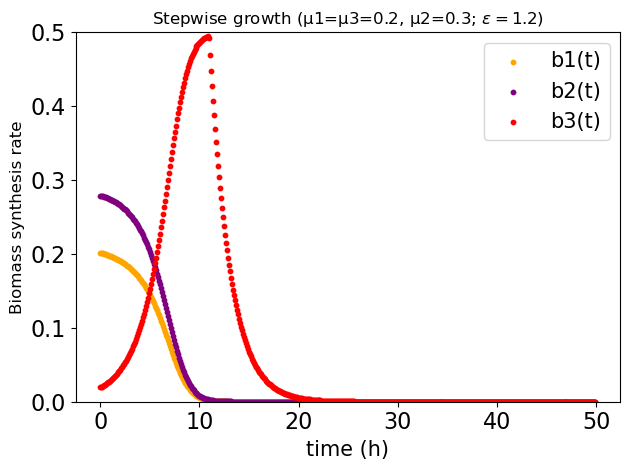

In [74]:
import matplotlib.pyplot as plt
plt.figure()
T_list=[0]
Fluxes1_list=[0.2018]
Fluxes2_list=[0.2787]
Fluxes3_list=[0.0195]
B1_vals=[0.39]
B2_vals=[0.59]
B3_vals=[0.02]

def B1(t):
    if(t<=0):
        return 0.39
    return B1_vals[int((t-1)/1)]*0.95+0.1*Fluxes1_list[-1]
def B2(t):
    if(t<=0):
        return 0.59
    return B2_vals[int((t-1)/1)]*0.95+0.1*Fluxes2_list[-1]
def B3(t):
    if(t<=0):
        return 0.02
    return B3_vals[int((t-1)/1)]*0.95+0.1*Fluxes3_list[-1]
A=1.2
for t in np.arange(1,500,1):
    B1_t = B1(t)
    B2_t = B2(t)
    B3_t = B3(t)
#     B1_vals.append(B1_t)
#     B2_vals.append(B2_t)
#     B3_vals.append(B3_t)
    b1=0.5*0.2*B1_vals[-1]*(math.pow(B2_vals[-1],A))/(0.2*B1_vals[-1]*(math.pow(B2_vals[-1],A))+0.3*B2_vals[-1]*(math.pow(B1_vals[-1],A))+0.2*B3_vals[-1])
    b2=0.5*0.3*B2_vals[-1]*(math.pow(B1_vals[-1],A))/(0.2*B1_vals[-1]*(math.pow(B2_vals[-1],A))+0.3*B2_vals[-1]*(math.pow(B1_vals[-1],A))+0.2*B3_vals[-1])
    b3=0.5*0.2*B3_vals[-1]/(0.2*B1_vals[-1]*(math.pow(B2_vals[-1],A))+0.3*B2_vals[-1]*(math.pow(B1_vals[-1],A))+0.2*B3_vals[-1])
    B1_vals.append(B1_t)
    B2_vals.append(B2_t)
    B3_vals.append(B3_t)
    
    model2.reactions.biomass3.upper_bound=b3
    model2.reactions.biomass2.upper_bound=b2
    model2.reactions.biomass1.upper_bound=b1
    model2.reactions.DI1X.upper_bound=3*B1_vals[-1]
    model2.reactions.DI2Y.upper_bound=3*B2_vals[-1]
    model2.reactions.DI3X.upper_bound=3*B3_vals[-1]
    sol = model2.optimize()
    obj_val = sol.objective_value
    Fluxes3=sol.fluxes.loc['biomass3']
    Fluxes2=sol.fluxes.loc['biomass2']
    Fluxes1=sol.fluxes.loc['biomass1']

    
    Fluxes1_list.append(Fluxes1)
    Fluxes2_list.append(Fluxes2)
    Fluxes3_list.append(Fluxes3)
    
    T=t/10
    T_list.append(T)
print(Fluxes1_list[0],Fluxes2_list[0],Fluxes3_list[0])           
plt.scatter(T_list,Fluxes1_list,color='orange',s=10)
plt.scatter(T_list,Fluxes2_list,color='purple',s=10)
plt.scatter(T_list,Fluxes3_list,color='red',s=10)
# plt.scatter(T_list,B1_vals,color='orange',s=10)
# plt.scatter(T_list,B2_vals,color='purple',s=10)
# plt.scatter(T_list,B3_vals,color='red',s=10)

plt.xlabel("time (h)",fontsize=15)

plt.ylim(0,0.5)
plt.title('Stepwise growth (µ1=µ3=0.2, µ2=0.3; 'r'$\varepsilon=1.2$'')',fontsize=12)
plt.ylabel("Biomass synthesis rate", fontsize=12)
plt.legend(['b1(t)','b2(t)','b3(t)'],loc='upper right')

# plt.ylim(0,1)
# plt.title('Stepwise growth (µ1=µ3=0.2, µ2=0.3; 'r'$\varepsilon=1.2$'')',fontsize=12)
# plt.ylabel("Cell number",fontsize=12)
# plt.legend(['B1(t)','B2(t)','B3(t)'],loc='upper right')

plt.rc('xtick', labelsize=16) 
plt.rc('ytick', labelsize=16)
plt.rcParams['legend.fontsize']=15
plt.tight_layout()
# plt.show()
plt.savefig('Only regulation between biomass1 and biomass2(Obj=b1+b2+b3)',dpi=300)

In [38]:
print(b1+b2+b3)

0.5


### Case 2 (Cell type 3 lost regulation from cell type 2 and still existed regulation to cell type 2.)

In [57]:
model1=model.copy()
model2=model1.copy()

<Figure size 640x480 with 0 Axes>

0.1506 0.3417 0.0077


Text(0.5, 0, 'time (h)')

(0.0, 0.5)

Text(0.5, 1.0, 'Stepwise growth (µ1=µ3=0.2, µ2=0.3; $\\varepsilon=0$)')

Text(0, 0.5, 'Biomass synthesis rate')

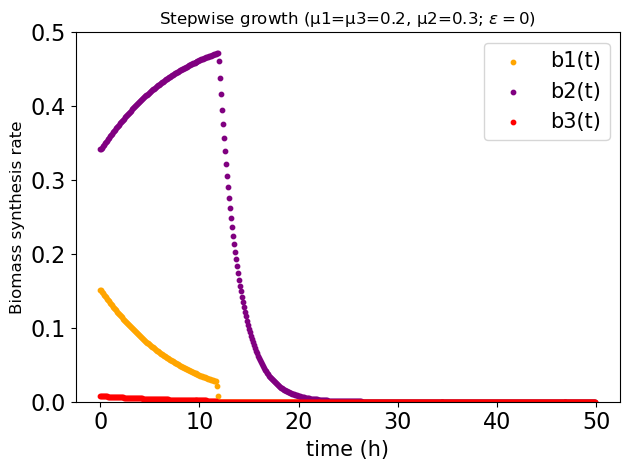

In [58]:
import matplotlib.pyplot as plt
plt.figure()
T_list=[0]
Fluxes1_list=[0.1506]
Fluxes2_list=[0.3417]
Fluxes3_list=[0.0077]
B1_vals=[0.39]
B2_vals=[0.59]
B3_vals=[0.02]

def B1(t):
    if(t<=0):
        return 0.39
    return B1_vals[int((t-1)/1)]*0.95+0.1*Fluxes1_list[-1]
def B2(t):
    if(t<=0):
        return 0.59
    return B2_vals[int((t-1)/1)]*0.95+0.1*Fluxes2_list[-1]
def B3(t):
    if(t<=0):
        return 0.02
    return B3_vals[int((t-1)/1)]*0.95+0.1*Fluxes3_list[-1]
A=0
for t in np.arange(1,500,1):
    B1_t = B1(t)
    B2_t = B2(t)
    B3_t = B3(t)
#     B1_vals.append(B1_t)
#     B2_vals.append(B2_t)
#     B3_vals.append(B3_t)
    b1=0.5*0.2*B1_vals[-1]*(math.pow(B2_vals[-1],A))/(0.2*B1_vals[-1]*(math.pow(B2_vals[-1],A))+0.3*B2_vals[-1]*(math.pow((B1_vals[-1]+B3_vals[-1]),A))+0.2*B3_vals[-1])
    b2=0.5*0.3*B2_vals[-1]*(math.pow((B1_vals[-1]+B3_vals[-1]),A))/(0.2*B1_vals[-1]*(math.pow(B2_vals[-1],A))+0.3*B2_vals[-1]*(math.pow((B1_vals[-1]+B3_vals[-1]),A))+0.2*B3_vals[-1])
    b3=0.5*0.2*B3_vals[-1]/(0.2*B1_vals[-1]*(math.pow(B2_vals[-1],A))+0.3*B2_vals[-1]*(math.pow((B1_vals[-1]+B3_vals[-1]),A))+0.2*B3_vals[-1])
    B1_vals.append(B1_t)
    B2_vals.append(B2_t)
    B3_vals.append(B3_t)
    
    model2.reactions.biomass3.upper_bound=b3
    model2.reactions.biomass2.upper_bound=b2
    model2.reactions.biomass1.upper_bound=b1
    model2.reactions.DI1X.upper_bound=3*B1_vals[-1]
    model2.reactions.DI2Y.upper_bound=3*B2_vals[-1]
    model2.reactions.DI3X.upper_bound=3*B3_vals[-1]
    sol = model2.optimize()
    obj_val = sol.objective_value
    Fluxes3=sol.fluxes.loc['biomass3']
    Fluxes2=sol.fluxes.loc['biomass2']
    Fluxes1=sol.fluxes.loc['biomass1']

    
    Fluxes1_list.append(Fluxes1)
    Fluxes2_list.append(Fluxes2)
    Fluxes3_list.append(Fluxes3)
    
    T=t/10
    T_list.append(T)
print(Fluxes1_list[0],Fluxes2_list[0],Fluxes3_list[0])           
plt.scatter(T_list,Fluxes1_list,color='orange',s=10)
plt.scatter(T_list,Fluxes2_list,color='purple',s=10)
plt.scatter(T_list,Fluxes3_list,color='red',s=10)
# plt.scatter(T_list,B1_vals,color='orange',s=10)
# plt.scatter(T_list,B2_vals,color='purple',s=10)
# plt.scatter(T_list,B3_vals,color='red',s=10)

plt.xlabel("time (h)",fontsize=15)

plt.ylim(0,0.5)
plt.title('Stepwise growth (µ1=µ3=0.2, µ2=0.3; 'r'$\varepsilon=0$'')',fontsize=12)
plt.ylabel("Biomass synthesis rate", fontsize=12)
plt.legend(['b1(t)','b2(t)','b3(t)'],loc='upper right')

# plt.ylim(0,1)
# plt.title('Stepwise growth (µ1=µ3=0.2, µ2=0.3; 'r'$\varepsilon=0$'')',fontsize=12)
# plt.ylabel("Cell number",fontsize=12)
# plt.legend(['B1(t)','B2(t)','B3(t)'],loc='upper right')

plt.rc('xtick', labelsize=16) 
plt.rc('ytick', labelsize=16)
plt.rcParams['legend.fontsize']=15
plt.tight_layout()
# plt.show()
plt.savefig('Only regulation between biomass1 and biomass2(Obj=b1+b2+b3)',dpi=300)

In [19]:
print(B1_vals[-1],B2_vals[-1],B3_vals[-1])

5.9264550771782915e-08 0.2869930498762703 0.7130068908591778


In [18]:
print(b1+b2+b3)

0.5


### Case 3 (Cell type lost regulation to cell type 2, but still existed regulation from cell type 2) 

In [92]:
model1=model.copy()
model2=model1.copy()

<Figure size 640x480 with 0 Axes>

0.1506 0.3417 0.0077


Text(0.5, 0, 'time (h)')

(0.0, 1.0)

Text(0.5, 1.0, 'Stepwise growth (µ1=µ3=0.2, µ2=0.3; $\\varepsilon=0$)')

Text(0, 0.5, 'Cell number')

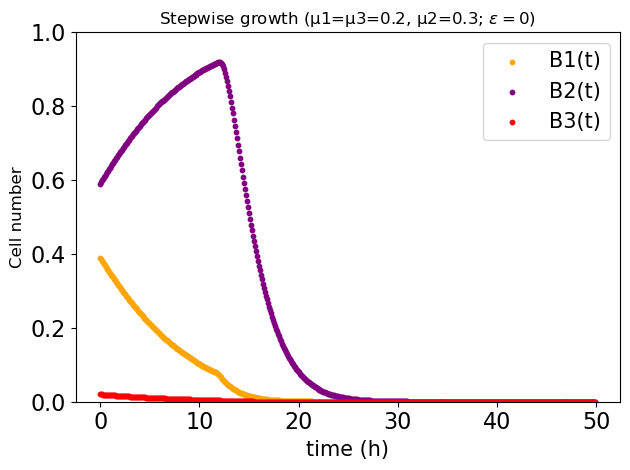

In [93]:
import matplotlib.pyplot as plt
plt.figure()
T_list=[0]
Fluxes1_list=[0.1506]
Fluxes2_list=[0.3417]
Fluxes3_list=[0.0077]
B1_vals=[0.39]
B2_vals=[0.59]
B3_vals=[0.02]

def B1(t):
    if(t<=0):
        return 0.39
    return B1_vals[int((t-1)/1)]*0.95+0.1*Fluxes1_list[-1]
def B2(t):
    if(t<=0):
        return 0.59
    return B2_vals[int((t-1)/1)]*0.95+0.1*Fluxes2_list[-1]
def B3(t):
    if(t<=0):
        return 0.02
    return B3_vals[int((t-1)/1)]*0.95+0.1*Fluxes3_list[-1]
A=0
for t in np.arange(1,500,1):
    B1_t = B1(t)
    B2_t = B2(t)
    B3_t = B3(t)
#     B1_vals.append(B1_t)
#     B2_vals.append(B2_t)
#     B3_vals.append(B3_t)
    b1=0.5*0.2*B1_vals[-1]*(math.pow(B2_vals[-1],A))/(0.2*B1_vals[-1]*(math.pow(B2_vals[-1],A))+0.3*B2_vals[-1]*(math.pow(B1_vals[-1],A))+0.2*B3_vals[-1]*(math.pow(B2_vals[-1],A)))
    b2=0.5*0.3*B2_vals[-1]*(math.pow(B1_vals[-1],A))/(0.2*B1_vals[-1]*(math.pow(B2_vals[-1],A))+0.3*B2_vals[-1]*(math.pow(B1_vals[-1],A))+0.2*B3_vals[-1]*(math.pow(B2_vals[-1],A)))
    b3=0.5*0.2*B3_vals[-1]*(math.pow(B2_vals[-1],A))/(0.2*B1_vals[-1]*(math.pow(B2_vals[-1],A))+0.3*B2_vals[-1]*(math.pow(B1_vals[-1],A))+0.2*B3_vals[-1]*(math.pow(B2_vals[-1],A)))
    B1_vals.append(B1_t)
    B2_vals.append(B2_t)
    B3_vals.append(B3_t)
    
    model2.reactions.biomass3.upper_bound=b3
    model2.reactions.biomass2.upper_bound=b2
    model2.reactions.biomass1.upper_bound=b1
    model2.reactions.DI1X.upper_bound=3*B1_vals[-1]
    model2.reactions.DI2Y.upper_bound=3*B2_vals[-1]
    model2.reactions.DI3X.upper_bound=3*B3_vals[-1]
    sol = model2.optimize()
    obj_val = sol.objective_value
    Fluxes3=sol.fluxes.loc['biomass3']
    Fluxes2=sol.fluxes.loc['biomass2']
    Fluxes1=sol.fluxes.loc['biomass1']

    
    Fluxes1_list.append(Fluxes1)
    Fluxes2_list.append(Fluxes2)
    Fluxes3_list.append(Fluxes3)
    
    T=t/10
    T_list.append(T)
print(Fluxes1_list[0],Fluxes2_list[0],Fluxes3_list[0])           
# plt.scatter(T_list,Fluxes1_list,color='orange',s=10)
# plt.scatter(T_list,Fluxes2_list,color='purple',s=10)
# plt.scatter(T_list,Fluxes3_list,color='red',s=10)
plt.scatter(T_list,B1_vals,color='orange',s=10)
plt.scatter(T_list,B2_vals,color='purple',s=10)
plt.scatter(T_list,B3_vals,color='red',s=10)

plt.xlabel("time (h)",fontsize=15)

# plt.ylim(0,0.5)
# plt.title('Stepwise growth (µ1=µ3=0.2, µ2=0.3; 'r'$\varepsilon=0$'')',fontsize=12)
# plt.ylabel("Biomass synthesis rate", fontsize=12)
# plt.legend(['b1(t)','b2(t)','b3(t)'],loc='upper right')

plt.ylim(0,1)
plt.title('Stepwise growth (µ1=µ3=0.2, µ2=0.3; 'r'$\varepsilon=0$'')',fontsize=12)
plt.ylabel("Cell number",fontsize=12)
plt.legend(['B1(t)','B2(t)','B3(t)'],loc='upper right')

plt.rc('xtick', labelsize=16) 
plt.rc('ytick', labelsize=16)
plt.rcParams['legend.fontsize']=15
plt.tight_layout()
# plt.show()
plt.savefig('Only regulation between biomass1 and biomass2(Obj=b1+b2+b3)',dpi=300)

## Without regulation high initial cell number

In [1]:
import math

In [10]:
model1=model.copy()
model2=model1.copy()

<Figure size 640x480 with 0 Axes>

0.1933 0.2899 0.0168


Text(0.5, 0, 't (month)')

(0.0, 1.0)

Text(0.5, 1.0, 'Stepwise growth (µ1=µ3=0.2, µ2=0.3; $\\varepsilon=1$)')

Text(0, 0.5, 'Cell number (billions)')

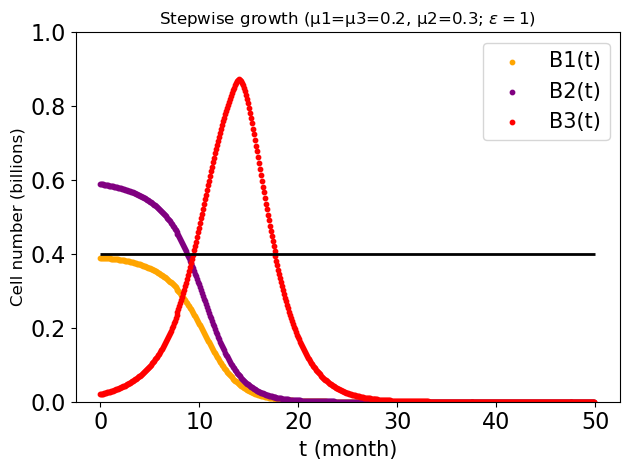

In [11]:
## B1=0.39; B2=0.59; B3=0.02; Fluxes1=0.1933; Fluxes2=0.2899; Fluxes3=0.0168
## B1=3.9; B2=5.9; B3=0.02; Fluxes1=0.1999; Fluxes2=0.2999; Fluxes3=0.0002
import matplotlib.pyplot as plt
plt.figure()
T_list=[0]
Fluxes1_list=[0.1933]
Fluxes2_list=[0.2899]
Fluxes3_list=[0.0168]
B1_vals=[0.39]
B2_vals=[0.59]
B3_vals=[0.02]

def B1(t):
    if(t<=0):
        return 0.39
    return B1_vals[int((t-1)/1)]*0.95+0.1*Fluxes1_list[-1]
def B2(t):
    if(t<=0):
        return 0.59
    return B2_vals[int((t-1)/1)]*0.95+0.1*Fluxes2_list[-1]
def B3(t):
    if(t<=0):
        return 0.02
    return B3_vals[int((t-1)/1)]*0.95+0.1*Fluxes3_list[-1]

for t in np.arange(1,500,1):
    B1_t = B1(t)
    B2_t = B2(t)
    B3_t = B3(t)
    
#     B1_vals.append(B1_t)
#     B2_vals.append(B2_t)
#     B3_vals.append(B3_t)
    
    b1=0.5*0.2*B1(t-0.1)*(math.pow(B2(t-0.1),1))/(0.2*B1(t-0.1)*(math.pow(B2(t-0.1),1))+0.3*B2(t-0.1)*(math.pow(B1(t-0.1),1))+0.2*B3(t-0.1))
    b2=0.5*0.3*B2(t-0.1)*(math.pow(B1(t-0.1),1))/(0.2*B1(t-0.1)*(math.pow(B2(t-0.1),1))+0.3*B2(t-0.1)*(math.pow(B1(t-0.1),1))+0.2*B3(t-0.1))
    b3=0.5*0.2*B3(t-0.1)/(0.2*B1(t-0.1)*(math.pow(B2(t-0.1),1))+0.3*B2(t-0.1)*(math.pow(B1(t-0.1),1))+0.2*B3(t-0.1))
    
    B1_vals.append(B1_t)
    B2_vals.append(B2_t)
    B3_vals.append(B3_t)
    
    model2.reactions.biomass3.upper_bound=b3
    model2.reactions.biomass2.upper_bound=b2
    model2.reactions.biomass1.upper_bound=b1
    model2.reactions.DI1X.upper_bound=3*B1_vals[-1]
    model2.reactions.DI2Y.upper_bound=3*B2_vals[-1]
    model2.reactions.DI3X.upper_bound=3*B3_vals[-1]
    sol = model2.optimize()
    obj_val = sol.objective_value
    Fluxes3=sol.fluxes.loc['biomass3']
    Fluxes2=sol.fluxes.loc['biomass2']
    Fluxes1=sol.fluxes.loc['biomass1']

    Fluxes1_list.append(Fluxes1)
    Fluxes2_list.append(Fluxes2)
    Fluxes3_list.append(Fluxes3)
    
    T=t/10
    T_list.append(T)
            
print(Fluxes1_list[0],Fluxes2_list[0],Fluxes3_list[0])
# plt.scatter(T_list,Fluxes1_list,color='orange',s=10)
# plt.scatter(T_list,Fluxes2_list,color='purple',s=10)
# plt.scatter(T_list,Fluxes3_list,color='red',s=10)
plt.scatter(T_list,B1_vals,color='orange',s=10)
plt.scatter(T_list,B2_vals,color='purple',s=10)
plt.scatter(T_list,B3_vals,color='red',s=10)

plt.xlabel("t (month)",fontsize=15)

# plt.ylabel("Biomass synthesis value")
# plt.legend(['b1','b2','b3'])

plt.ylim(0,1)
plt.hlines(y=0.4, xmin=0, xmax=50,colors='black', linestyles='solid',linewidth=2)
plt.title('Stepwise growth (µ1=µ3=0.2, µ2=0.3; 'r'$\varepsilon=1$'')',fontsize=12)
plt.ylabel("Cell number (billions)",fontsize=12)
plt.legend(['B1(t)','B2(t)','B3(t)'],loc='upper right')

plt.rc('xtick', labelsize=16) 
plt.rc('ytick', labelsize=16)
plt.rcParams['legend.fontsize']=15
plt.tight_layout()
# plt.show()
plt.savefig('Only regulation between biomass1 and biomass2(Obj=b1+b2+b3)',dpi=600)

## The influence of cells' death rate

I: [kD=0.5 (Cell1 and Cell2); kD=0.5 (Cell3)]
II: [kD=0.9 (Cell1 and Cell2); kD=0.5 (Cell3)]
III: [kD=0.9 (Cell1 and Cell2); kD=0.9 (Cell3)]
IV: [kD=0.5 (Cell1 and Cell2); kD=0.9 (Cell3)]

In [18]:
import math
model1=model.copy()
model2=model1.copy()

<Figure size 640x480 with 0 Axes>

0.1933 0.2899 0.0168


Text(0.5, 0, 't (month)')

(0.0, 1.0)

Text(0.5, 1.0, 'Stepwise growth (µ1=µ3=0.2, µ2=0.3; $\\varepsilon=1$)')

Text(0, 0.5, 'Cell number (billions)')

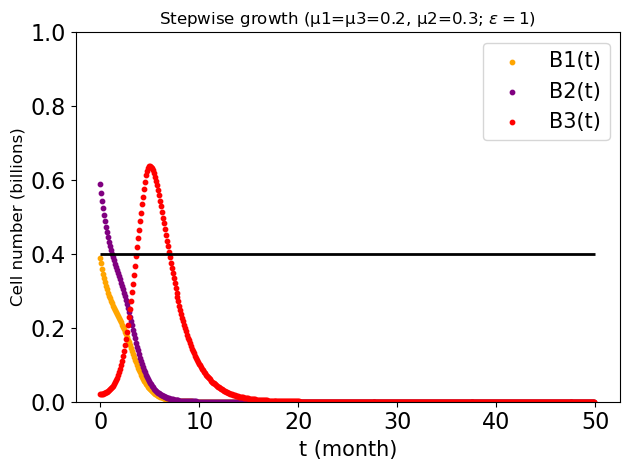

In [19]:
#Kd1=Kd2=Kd3=0.5; Fluxes1=0.1933; Fluxes2=0.2899; Fluxes3=0.0168;
#Kd1=Kd2=0.9; Kd3=0.5; Fluxes1=0.1933; Fluxes2=0.2899; Fluxes3=0.0168;
#Kd1=Kd2=Kd3=0.9; Fluxes1=0.1933; Fluxes2=0.2899; Fluxes3=0.0168;
#Kd1=Kd1=0.5; Kd1=0.9; Fluxes1=0.1933; Fluxes2=0.2899; Fluxes3=0.0168;
import matplotlib.pyplot as plt
plt.figure()
T_list=[0]
Fluxes1_list=[0.1933]
Fluxes2_list=[0.2899]
Fluxes3_list=[0.0168]
B1_vals=[0.39]
B2_vals=[0.59]
B3_vals=[0.02]

def B1(t):
    if(t<=0):
        return 0.39
    return B1_vals[int((t-1)/1)]*0.91+0.1*Fluxes1_list[-1]
def B2(t):
    if(t<=0):
        return 0.59
    return B2_vals[int((t-1)/1)]*0.91+0.1*Fluxes2_list[-1]
def B3(t):
    if(t<=0):
        return 0.02
    return B3_vals[int((t-1)/1)]*0.95+0.1*Fluxes3_list[-1]

for t in np.arange(1,500,1):
    B1_t = B1(t)
    B2_t = B2(t)
    B3_t = B3(t)

    b1=0.5*0.2*B1_vals[-1]*(math.pow(B2_vals[-1],1))/(0.2*B1_vals[-1]*(math.pow(B2_vals[-1],1))+0.3*B2_vals[-1]*(math.pow(B1_vals[-1],1))+0.2*B3_vals[-1])
    b2=0.5*0.3*B2_vals[-1]*(math.pow(B1_vals[-1],1))/(0.2*B1_vals[-1]*(math.pow(B2_vals[-1],1))+0.3*B2_vals[-1]*(math.pow(B1_vals[-1],1))+0.2*B3_vals[-1])
    b3=0.5*0.2*B3_vals[-1]/(0.2*B1_vals[-1]*(math.pow(B2_vals[-1],1))+0.3*B2_vals[-1]*(math.pow(B1_vals[-1],1))+0.2*B3_vals[-1])
    B1_vals.append(B1_t)
    B2_vals.append(B2_t)
    B3_vals.append(B3_t)
    
    model2.reactions.biomass3.upper_bound=b3
    model2.reactions.biomass2.upper_bound=b2
    model2.reactions.biomass1.upper_bound=b1
    model2.reactions.DI1X.upper_bound=3*B1_vals[-1]
    model2.reactions.DI2Y.upper_bound=3*B2_vals[-1]
    model2.reactions.DI3X.upper_bound=3*B3_vals[-1]
    sol = model2.optimize()
    obj_val = sol.objective_value
    Fluxes3=sol.fluxes.loc['biomass3']
    Fluxes2=sol.fluxes.loc['biomass2']
    Fluxes1=sol.fluxes.loc['biomass1']

    
    Fluxes1_list.append(Fluxes1)
    Fluxes2_list.append(Fluxes2)
    Fluxes3_list.append(Fluxes3)
    
    T=t/10
    T_list.append(T)
            
print(Fluxes1_list[0],Fluxes2_list[0],Fluxes3_list[0])

# plt.scatter(T_list,Fluxes1_list,color='orange',s=10)
# plt.scatter(T_list,Fluxes2_list,color='purple',s=10)
# plt.scatter(T_list,Fluxes3_list,color='red',s=10)
plt.scatter(T_list,B1_vals,color='orange',s=10)
plt.scatter(T_list,B2_vals,color='purple',s=10)
plt.scatter(T_list,B3_vals,color='red',s=10)

plt.xlabel("t (month)",fontsize=15)
# plt.ylabel("Biomass synthesis value")
# plt.legend(['b1(t)','b2(t)','b3(t)'])

plt.ylim(0,1)
plt.hlines(y=0.4, xmin=0, xmax=50,colors='black', linestyles='solid',linewidth=2)
plt.title('Stepwise growth (µ1=µ3=0.2, µ2=0.3; 'r'$\varepsilon=1$'')',fontsize=12)
plt.ylabel("Cell number (billions)",fontsize=12)
plt.legend(['B1(t)','B2(t)','B3(t)'],loc='upper right')
plt.rc('xtick', labelsize=16) 
plt.rc('ytick', labelsize=16)
plt.rcParams['legend.fontsize']=15
plt.tight_layout()
# plt.show()
plt.savefig('Only regulation between biomass1 and biomass2(Obj=b1+b2+b3)',dpi=600)

## With regulation

### Regulation method I (Three cell types regulated each other.)

In [12]:
import math
model1=model.copy()
model2=model1.copy()

<Figure size 640x480 with 0 Axes>

0.1429 0.2143 0.1429


Text(0.5, 0, 't (month)')

Text(0.5, 1.0, 'Stepwise growth (µ1=µ3=0.2, µ2=0.3; $\\varepsilon=1$; $\\gamma=1$)')

(0.0, 1.0)

Text(0, 0.5, 'Cell number (billions)')

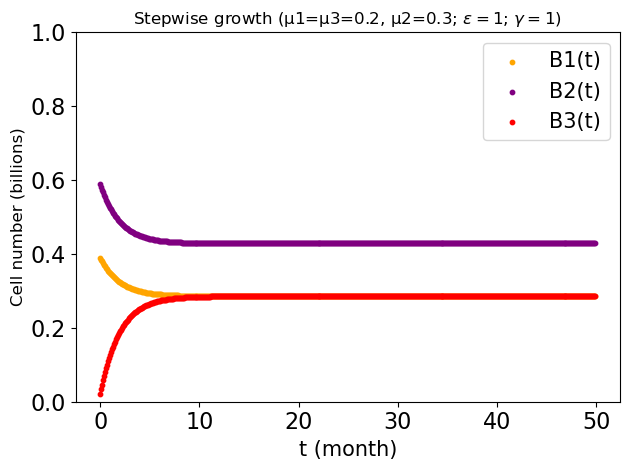

In [13]:
### 𝛆=1;𝞬=0;Fluxes1=0.1933;Fluxes2=0.2899;Fluxes3=0.0168
### 𝛆=1;𝞬=0.2;Fluxes1=0.1893;Fluxes2=0.2839;Fluxes3=0.0268
### 𝛆=1;𝞬=0.5;Fluxes1=0.1789;Fluxes2=0.2684;Fluxes3=0.0527
### 𝛆=1;𝞬=1;Fluxes1=0.1429;Fluxes2=0.2143;Fluxes3=0.1429
### 𝛆=1;𝞬=1.5;Fluxes1=0.0849;Fluxes2=0.1273;Fluxes3=0.2878
import matplotlib.pyplot as plt
plt.figure()
T_list=[0]
Fluxes1_list=[0.1429]
Fluxes2_list=[0.2143]
Fluxes3_list=[0.1429]
B1_vals=[0.39]
B2_vals=[0.59]
B3_vals=[0.02]

def B1(t):
    if(t<=0):
        return 0.39
    return B1_vals[int((t-1)/1)]*0.95+0.1*Fluxes1_list[-1]
def B2(t):
    if(t<=0):
        return 0.59
    return B2_vals[int((t-1)/1)]*0.95+0.1*Fluxes2_list[-1]
def B3(t):
    if(t<=0):
        return 0.02
    return B3_vals[int((t-1)/1)]*0.95+0.1*Fluxes3_list[-1]

A=1
for t in np.arange(1,500,1):
    B1_t = B1(t)
    B2_t = B2(t)
    B3_t = B3(t)
    
#     B1_vals.append(B1_t)
#     B2_vals.append(B2_t)
#     B3_vals.append(B3_t)
    
    b1=0.5*0.2*B1_vals[-1]*(math.pow(B2_vals[-1],1))*(math.pow(B3_vals[-1],A))/(0.2*B1_vals[-1]*(math.pow(B2_vals[-1],1))*(math.pow(B3_vals[-1],A))+0.3*B2_vals[-1]*(math.pow(B1_vals[-1],1))*(math.pow(B3_vals[-1],A))+0.2*B3_vals[-1]*(math.pow(B1_vals[-1],A))*(math.pow(B2_vals[-1],A))) 
    b2=0.5*0.3*B2_vals[-1]*(math.pow(B1_vals[-1],1))*(math.pow(B3_vals[-1],A))/(0.2*B1_vals[-1]*(math.pow(B2_vals[-1],1))*(math.pow(B3_vals[-1],A))+0.3*B2_vals[-1]*(math.pow(B1_vals[-1],1))*(math.pow(B3_vals[-1],A))+0.2*B3_vals[-1]*(math.pow(B1_vals[-1],A))*(math.pow(B2_vals[-1],A)))
    b3=0.5*0.2*B3_vals[-1]*(math.pow(B1_vals[-1],A))*(math.pow(B2_vals[-1],A))/(0.2*B1_vals[-1]*(math.pow(B2_vals[-1],1))*(math.pow(B3_vals[-1],A))+0.3*B2_vals[-1]*(math.pow(B1_vals[-1],1))*(math.pow(B3_vals[-1],A))+0.2*B3_vals[-1]*(math.pow(B1_vals[-1],A))*(math.pow(B2_vals[-1],A)))
    
    B1_vals.append(B1_t)
    B2_vals.append(B2_t)
    B3_vals.append(B3_t)
   
    model2.reactions.biomass1.upper_bound=b1
    model2.reactions.biomass2.upper_bound=b2
    model2.reactions.biomass3.upper_bound=b3
    model2.reactions.DI1X.upper_bound=3*B1_vals[-1]
    model2.reactions.DI2Y.upper_bound=3*B2_vals[-1]
    model2.reactions.DI3X.upper_bound=3*B3_vals[-1]
    sol = model2.optimize()
    obj_val = sol.objective_value
    Fluxes1=sol.fluxes.loc['biomass1']
    Fluxes2=sol.fluxes.loc['biomass2']
    Fluxes3=sol.fluxes.loc['biomass3']
  
    Fluxes1_list.append(Fluxes1)
    Fluxes2_list.append(Fluxes2)
    Fluxes3_list.append(Fluxes3)

    T=t/10
    T_list.append(T)
print(Fluxes1_list[0],Fluxes2_list[0],Fluxes3_list[0])
# plt.scatter(T_list,Fluxes1_list,color='orange',s=10)
# plt.scatter(T_list,Fluxes2_list,color='purple',s=10)
# plt.scatter(T_list,Fluxes3_list,color='red',s=10)
plt.scatter(T_list,B1_vals,color='orange',s=10)
plt.scatter(T_list,B2_vals,color='purple',s=10)
plt.scatter(T_list,B3_vals,color='red',s=10)


plt.xlabel("t (month)",fontsize=15)
plt.title('Stepwise growth (µ1=µ3=0.2, µ2=0.3; 'r'$\varepsilon=1$''; 'r'$\gamma=1$'')',fontsize=12)

# plt.ylabel("Biomass value (B) and biomass synthesis rate (b)")
# plt.legend(['b1(t)','b2(t)','b3(t)','B1(t)','B2(t)','B3(t)'])

plt.ylim(0,1)
plt.ylabel("Cell number (billions)",fontsize=12)
plt.legend(['B1(t)','B2(t)','B3(t)'],loc='upper right')

# plt.ylim(0,0.5)
# plt.ylabel("Biomass synthesis rate",fontsize=12)
# plt.legend(['b1(t)','b2(t)','b3(t)'],loc='upper right')

plt.rc('xtick', labelsize=16) 
plt.rc('ytick', labelsize=16)
plt.rcParams['legend.fontsize'] = 15
plt.tight_layout()
# plt.show()
plt.savefig('Regulation among three cell types (Obj=b1+b2+b3)',dpi=600)

In [99]:
print(Fluxes1_list[-1],Fluxes2_list[-1],Fluxes3_list[-1])

0.15285210495855547 0.22927815743783317 0.1178697376036113


In [100]:
print(B1_vals[-1], B2_vals[-1], B3_vals[-1])

0.305704209917096 0.4585563148756829 0.2357394752072202


### Regulation method II (Cell type3 did not regulate other two.)

In [23]:
import math
model1=model.copy()
model2=model1.copy()

<Figure size 640x480 with 0 Axes>

0.1933 0.2899 0.0168


Text(0.5, 0, 't (month)')

Text(0.5, 1.0, 'Stepwise growth (µ1=µ3=0.2, µ2=0.3; $\\varepsilon=1$; $\\gamma=0$)')

(0.0, 1.0)

Text(0, 0.5, 'Cell number (billions)')

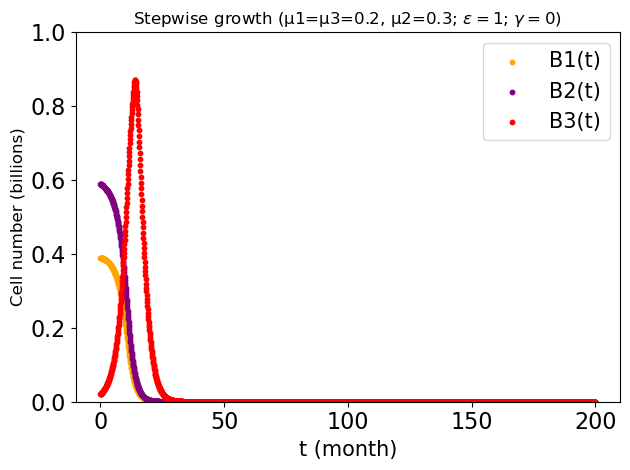

In [24]:
### 𝛆=1;𝞬=0;Fluxes1=0.1933;Fluxes1=0.2899;Fluxes1=0.0168
### 𝛆=1;𝞬=0.2;Fluxes1=0.1950;Fluxes2=0.2924;Fluxes3=0.0126
### 𝛆=1;𝞬=0.3;Fluxes1=0.1956;Fluxes2=0.2934;Fluxes3=0.0110
### 𝛆=1;𝞬=0.4;Fluxes1=0.1962;Fluxes2=0.2943;Fluxes3=0.0095
### 𝛆=1;𝞬=0.5;Fluxes1=0.1967;Fluxes2=0.2951;Fluxes3=0.0082

import matplotlib.pyplot as plt
plt.figure()
T_list=[0]
Fluxes1_list=[0.1933]
Fluxes2_list=[0.2899]
Fluxes3_list=[0.0168]
B1_vals=[0.39]
B2_vals=[0.59]
B3_vals=[0.02]

def B1(t):
    if(t<=0):
        return 0.39
    return B1_vals[int((t-1)/1)]*0.95+0.1*Fluxes1_list[-1]
def B2(t):
    if(t<=0):
        return 0.59
    return B2_vals[int((t-1)/1)]*0.95+0.1*Fluxes2_list[-1]
def B3(t):
    if(t<=0):
        return 0.02
    return B3_vals[int((t-1)/1)]*0.95+0.1*Fluxes3_list[-1]

A=0
for t in np.arange(1,2000,1):
    B1_t = B1(t)
    B2_t = B2(t)
    B3_t = B3(t)
    
#     B1_vals.append(B1_t)
#     B2_vals.append(B2_t)
#     B3_vals.append(B3_t)

    b1=0.5*0.2*B1_vals[-1]*(math.pow(B2_vals[-1],1))/(0.2*B1_vals[-1]*(math.pow(B2_vals[-1],1))+0.3*B2_vals[-1]*(math.pow(B1_vals[-1],1))+0.2*B3_vals[-1]*(math.pow(B1_vals[-1],A))*(math.pow(B2_vals[-1],A))) 
    b2=0.5*0.3*B2_vals[-1]*(math.pow(B1_vals[-1],1))/(0.2*B1_vals[-1]*(math.pow(B2_vals[-1],1))+0.3*B2_vals[-1]*(math.pow(B1_vals[-1],1))+0.2*B3_vals[-1]*(math.pow(B1_vals[-1],A))*(math.pow(B2_vals[-1],A)))
    b3=0.5*0.2*B3_vals[-1]*(math.pow(B1_vals[-1],A))*(math.pow(B2_vals[-1],A))/(0.2*B1_vals[-1]*(math.pow(B2_vals[-1],1))+0.3*B2_vals[-1]*(math.pow(B1_vals[-1],1))+0.2*B3_vals[-1]*(math.pow(B1_vals[-1],A))*(math.pow(B2_vals[-1],A)))
    
    B1_vals.append(B1_t)
    B2_vals.append(B2_t)
    B3_vals.append(B3_t)
   
    model2.reactions.biomass1.upper_bound=b1
    model2.reactions.biomass2.upper_bound=b2
    model2.reactions.biomass3.upper_bound=b3
    model2.reactions.DI1X.upper_bound=3*B1_vals[-1]
    model2.reactions.DI2Y.upper_bound=3*B2_vals[-1]
    model2.reactions.DI3X.upper_bound=3*B3_vals[-1]
    sol = model2.optimize()
    obj_val = sol.objective_value
    Fluxes1=sol.fluxes.loc['biomass1']
    Fluxes2=sol.fluxes.loc['biomass2']
    Fluxes3=sol.fluxes.loc['biomass3']
  
    Fluxes1_list.append(Fluxes1)
    Fluxes2_list.append(Fluxes2)
    Fluxes3_list.append(Fluxes3)
    
    T=t/10
    T_list.append(T)
print(Fluxes1_list[0],Fluxes2_list[0],Fluxes3_list[0])

# plt.scatter(T_list,Fluxes1_list,color='orange',s=10)
# plt.scatter(T_list,Fluxes2_list,color='purple',s=10)
# plt.scatter(T_list,Fluxes3_list,color='red',s=10)
plt.scatter(T_list,B1_vals,color='orange',s=10)
plt.scatter(T_list,B2_vals,color='purple',s=10)
plt.scatter(T_list,B3_vals,color='red',s=10)

plt.xlabel("t (month)",fontsize=15)
plt.title('Stepwise growth (µ1=µ3=0.2, µ2=0.3; 'r'$\varepsilon=1$''; 'r'$\gamma=0$'')',fontsize=12)
# plt.ylabel("Biomass value (B) and biomass synthesis rate (b)")
# plt.legend(['b1','b2','b3','B1','B2','B3'])

plt.ylim(0,1)
plt.ylabel("Cell number (billions)",fontsize=12)
plt.legend(['B1(t)','B2(t)','B3(t)'],loc='upper right')

# plt.ylim(0,0.5)
# plt.ylabel("Biomass synthesis rate",fontsize=12)
# plt.legend(['b1(t)','b2(t)','b3(t)'],loc='upper right')

plt.rc('xtick', labelsize=16) 
plt.rc('ytick', labelsize=16)
plt.rcParams['legend.fontsize'] = 15
plt.tight_layout()
# plt.show()
plt.savefig('Regulation for the third cell type (Obj=b1+b2+b3)',dpi=600)

### Regulation method III (Cell type3 and cell type2 only regulated each other.)

In [236]:
import math
model1=model.copy()
model2=model1.copy()

<Figure size 640x480 with 0 Axes>

0.4552 0.0202 0.0246


Text(0.5, 0, 'time (h)')

Text(0.5, 1.0, 'Stepwise growth (µ1=µ3=0.2, µ2=0.3; δ=1; $\\gamma=0.9$)')

(0.0, 1.0)

Text(0, 0.5, 'Cell number')

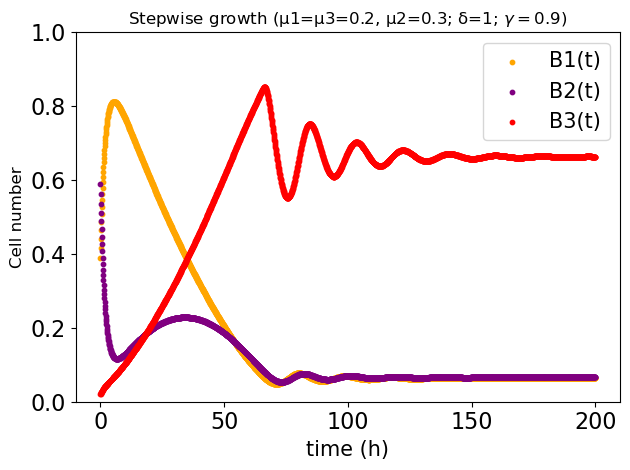

In [238]:
### 𝛆=1
import matplotlib.pyplot as plt
plt.figure()
T_list=[0]
Fluxes1_list=[0.4552]
Fluxes2_list=[0.0202]
Fluxes3_list=[0.0246]
B1_vals=[0.39]
B2_vals=[0.59]
B3_vals=[0.02]

def B1(t):
    if(t<=0):
        return 0.39
    return B1_vals[int((t-1)/1)]*0.95+0.1*Fluxes1_list[-1]
def B2(t):
    if(t<=0):
        return 0.59
    return B2_vals[int((t-1)/1)]*0.95+0.1*Fluxes2_list[-1]
def B3(t):
    if(t<=0):
        return 0.02
    return B3_vals[int((t-1)/1)]*0.95+0.1*Fluxes3_list[-1]

for t in np.arange(1,2000,1):
    B1_t = B1(t)
    B2_t = B2(t)
    B3_t = B3(t)
#     B1_vals.append(B1_t)
#     B2_vals.append(B2_t)
#     B3_vals.append(B3_t)
    b1=0.5*0.2*B1_vals[-1]*(math.pow(B2_vals[-1],1))/(0.2*B1_vals[-1]*(math.pow(B2_vals[-1],1))+0.3*B2_vals[-1]*(math.pow(B1_vals[-1],1))*(math.pow(B3_vals[-1],0.9))+0.2*B3_vals[-1]*(math.pow(B2_vals[-1],0.9))) 
    b2=0.5*0.3*B2_vals[-1]*(math.pow(B1_vals[-1],1))*(math.pow(B3_vals[-1],0.9))/(0.2*B1_vals[-1]*(math.pow(B2_vals[-1],1))+0.3*B2_vals[-1]*(math.pow(B1_vals[-1],1))*(math.pow(B3_vals[-1],0.9))+0.2*B3_vals[-1]*(math.pow(B2_vals[-1],0.9)))
    b3=0.5*0.2*B3_vals[-1]*(math.pow(B2_vals[-1],0.9))/(0.2*B1_vals[-1]*(math.pow(B2_vals[-1],1))+0.3*B2_vals[-1]*(math.pow(B1_vals[-1],1))*(math.pow(B3_vals[-1],0.9))+0.2*B3_vals[-1]*(math.pow(B2_vals[-1],0.9)))
    B1_vals.append(B1_t)
    B2_vals.append(B2_t)
    B3_vals.append(B3_t)
   
    model2.reactions.biomass1.upper_bound=b1
    model2.reactions.biomass2.upper_bound=b2
    model2.reactions.biomass3.upper_bound=b3
    model2.reactions.DI1X.upper_bound=3*B1_vals[-1]
    model2.reactions.DI2Y.upper_bound=3*B2_vals[-1]
    model2.reactions.DI3X.upper_bound=3*B3_vals[-1]
    sol = model2.optimize()
    obj_val = sol.objective_value
    Fluxes1=sol.fluxes.loc['biomass1']
    Fluxes2=sol.fluxes.loc['biomass2']
    Fluxes3=sol.fluxes.loc['biomass3']
  
    Fluxes1_list.append(Fluxes1)
    Fluxes2_list.append(Fluxes2)
    Fluxes3_list.append(Fluxes3)
    T=t/10
    T_list.append(T)        
print(Fluxes1_list[0],Fluxes2_list[0],Fluxes3_list[0])

# plt.scatter(T_list,Fluxes1_list,color='orange',s=10)
# plt.scatter(T_list,Fluxes2_list,color='purple',s=10)
# plt.scatter(T_list,Fluxes3_list,color='red',s=10)
plt.scatter(T_list,B1_vals,color='orange',s=10)
plt.scatter(T_list,B2_vals,color='purple',s=10)
plt.scatter(T_list,B3_vals,color='red',s=10)

plt.xlabel("time (h)",fontsize=15)
plt.title('Stepwise growth (µ1=µ3=0.2, µ2=0.3; 'r'$\varepsilon=1$''; 'r'$\gamma=0.9$'')',fontsize=12)
# plt.ylabel("Biomass value (B) and biomass synthesis rate (b)")
# plt.legend(['b1','b2','b3','B1','B2','B3'])
plt.ylim(0,1)
plt.ylabel("Cell number",fontsize=12)
plt.legend(['B1(t)','B2(t)','B3(t)'],loc='upper right')

# plt.ylim(0,0.5)
# plt.ylabel("Biomass synthesis rate",fontsize=12)
# plt.legend(['b1(t)','b2(t)','b3(t)'],loc='upper right')

plt.rc('xtick', labelsize=16) 
plt.rc('ytick', labelsize=16)
plt.rcParams['legend.fontsize'] = 15
plt.tight_layout()
# plt.show()
plt.savefig('Regulation for the third cell type (Obj=b1+b2+b3)',dpi=300)

### Regulation method IV (Cell type3 only regulated by cell type2.)

In [88]:
import math
model1=model.copy()
model2=model1.copy()

<Figure size 640x480 with 0 Axes>

0.1948 0.2922 0.013


Text(0.5, 0, 'time (h)')

Text(0.5, 1.0, 'Stepwise growth (µ1=µ3=0.2, µ2=0.3; $\\varepsilon=1$; $\\gamma=0$)')

(0.0, 0.5)

Text(0, 0.5, 'Biomass synthesis rate')

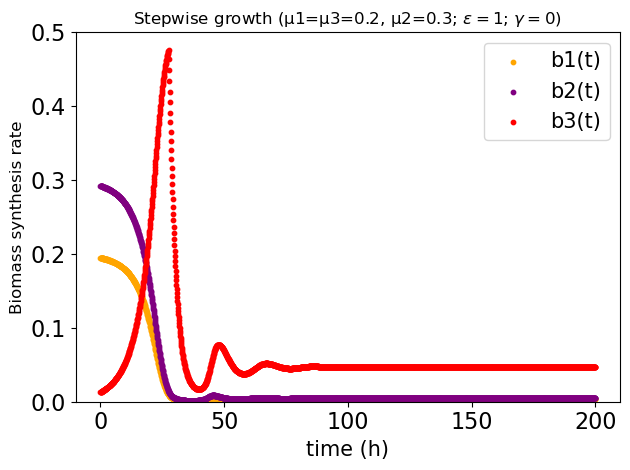

In [89]:
### 𝛆=1;𝞬=0;Fluxes1=0.1933;Fluxes1=0.2899;Fluxes1=0.0168
### 𝛆=1;𝞬=0.5;Fluxes1=0.1948;Fluxes1=0.2922;Fluxes1=0.0130
### 𝛆=1;𝞬=0.8;Fluxes1=0.1955;Fluxes1=0.2933;Fluxes1=0.0112
### 𝛆=1;𝞬=1;Fluxes1=0.1960;Fluxes1=0.2940;Fluxes1=0.0101

import matplotlib.pyplot as plt
plt.figure()
T_list=[0]
Fluxes1_list=[0.1948]
Fluxes2_list=[0.2922]
Fluxes3_list=[0.0130]
B1_vals=[0.39]
B2_vals=[0.59]
B3_vals=[0.02]

def B1(t):
    if(t<=0):
        return 0.39
    return B1_vals[int((t-1)/1)]*0.95+0.1*Fluxes1_list[-1]
def B2(t):
    if(t<=0):
        return 0.59
    return B2_vals[int((t-1)/1)]*0.95+0.1*Fluxes2_list[-1]
def B3(t):
    if(t<=0):
        return 0.02
    return B3_vals[int((t-1)/1)]*0.95+0.1*Fluxes3_list[-1]
A=0.5
for t in np.arange(1,2000,1):
    B1_t = B1(t)
    B2_t = B2(t)
    B3_t = B3(t)
#     B1_vals.append(B1_t)
#     B2_vals.append(B2_t)
#     B3_vals.append(B3_t)

    b1=0.5*0.2*B1_vals[-1]*(math.pow(B2_vals[-1],1))/(0.2*B1_vals[-1]*(math.pow(B2_vals[-1],1))+0.3*B2_vals[-1]*(math.pow(B1_vals[-1],1))+0.2*B3_vals[-1]*(math.pow(B2_vals[-1],A))) 
    b2=0.5*0.3*B2_vals[-1]*(math.pow(B1_vals[-1],1))/(0.2*B1_vals[-1]*(math.pow(B2_vals[-1],1))+0.3*B2_vals[-1]*(math.pow(B1_vals[-1],1))+0.2*B3_vals[-1]*(math.pow(B2_vals[-1],A)))
    b3=0.5*0.2*B3_vals[-1]*(math.pow(B2_vals[-1],A))/(0.2*B1_vals[-1]*(math.pow(B2_vals[-1],1))+0.3*B2_vals[-1]*(math.pow(B1_vals[-1],1))+0.2*B3_vals[-1]*(math.pow(B2_vals[-1],A)))
    
    B1_vals.append(B1_t)
    B2_vals.append(B2_t)
    B3_vals.append(B3_t) 
        
    model2.reactions.biomass1.upper_bound=b1
    model2.reactions.biomass2.upper_bound=b2
    model2.reactions.biomass3.upper_bound=b3
    model2.reactions.DI1X.upper_bound=3*B1_vals[-1]
    model2.reactions.DI2Y.upper_bound=3*B2_vals[-1]
    model2.reactions.DI3X.upper_bound=3*B3_vals[-1]
    sol = model2.optimize()
    obj_val = sol.objective_value
    Fluxes1=sol.fluxes.loc['biomass1']
    Fluxes2=sol.fluxes.loc['biomass2']
    Fluxes3=sol.fluxes.loc['biomass3']
    Fluxes1_list.append(Fluxes1)
    Fluxes2_list.append(Fluxes2)
    Fluxes3_list.append(Fluxes3)
    T=t/10
    T_list.append(T)        
print(Fluxes1_list[0],Fluxes2_list[0],Fluxes3_list[0])

plt.scatter(T_list,Fluxes1_list,color='orange',s=10)
plt.scatter(T_list,Fluxes2_list,color='purple',s=10)
plt.scatter(T_list,Fluxes3_list,color='red',s=10)
# plt.scatter(T_list,B1_vals,color='orange',s=10)
# plt.scatter(T_list,B2_vals,color='purple',s=10)
# plt.scatter(T_list,B3_vals,color='red',s=10)

plt.xlabel("time (h)",fontsize=15)
plt.title('Stepwise growth (µ1=µ3=0.2, µ2=0.3; 'r'$\varepsilon=1$''; 'r'$\gamma=0$'')',fontsize=12)
# plt.ylabel("Biomass value (B) and biomass synthesis rate (b)")
# plt.legend(['b1','b2','b3','B1','B2','B3'])
# plt.ylim(0,1)
# plt.ylabel("Cell number",fontsize=12)
# plt.legend(['B1(t)','B2(t)','B3(t)'],loc='upper right')

plt.ylim(0,0.5)
plt.ylabel("Biomass synthesis rate",fontsize=12)
plt.legend(['b1(t)','b2(t)','b3(t)'],loc='upper right')

plt.rc('xtick', labelsize=16) 
plt.rc('ytick', labelsize=16)
plt.rcParams['legend.fontsize'] = 15
plt.tight_layout()
plt.show()
# plt.savefig('Regulation for the third cell type (Obj=b1+b2+b3)',dpi=300)

## Treatment evaluation

### Therapy 1 (Decreasing the tumor cell number only (specific drugs))

In [36]:
import math
model1=model.copy()
model2=model1.copy()

<Figure size 640x480 with 0 Axes>

0.1318 0.1978 0.1704


Text(0.5, 0, 'time (h)')

(0.0, 1.0)

Text(0, 0.5, 'Cell number')

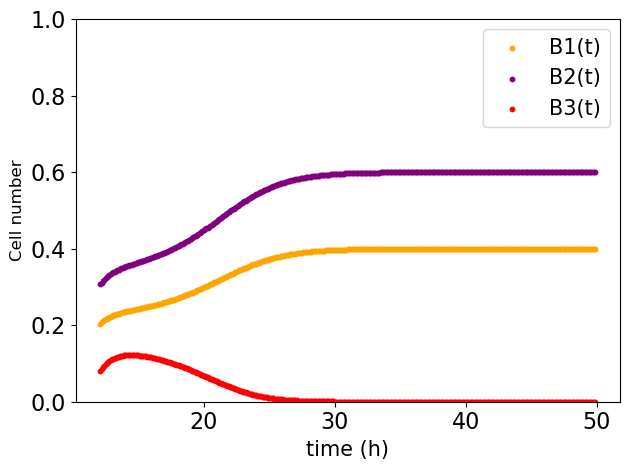

In [37]:
### 𝛆=1
import matplotlib.pyplot as plt
plt.figure()
T_list=[12.1]
Fluxes1_list=[0.1318]
Fluxes2_list=[0.1978]
Fluxes3_list=[0.1704]
B1_vals=[0.2042]
B2_vals=[0.3064]
B3_vals=[0.0809]

def B1(t):
    if(t<=121):
        return 0.2042
    return B1_vals[int((t-122)/1)]*0.95+0.1*Fluxes1_list[-1]
def B2(t):
    if(t<=121):
        return 0.3064
    return B2_vals[int((t-122)/1)]*0.95+0.1*Fluxes2_list[-1]
def B3(t):
    if(t<=121):
        return 0.0809
    return B3_vals[int((t-122)/1)]*0.85+0.1*Fluxes3_list[-1]

for t in np.arange(122,500,1):
    B1_t = B1(t)
    B2_t = B2(t)
    B3_t = B3(t)
#     B1_vals.append(B1_t)
#     B2_vals.append(B2_t)
#     B3_vals.append(B3_t)
        
    b1=0.5*0.2*B1_vals[-1]*(math.pow(B2_vals[-1],1))/(0.2*B1_vals[-1]*(math.pow(B2_vals[-1],1))+0.3*B2_vals[-1]*(math.pow(B1_vals[-1],1))+0.2*B3_vals[-1])
    b2=0.5*0.3*B2_vals[-1]*(math.pow(B1_vals[-1],1))/(0.2*B1_vals[-1]*(math.pow(B2_vals[-1],1))+0.3*B2_vals[-1]*(math.pow(B1_vals[-1],1))+0.2*B3_vals[-1])
    b3=0.5*0.2*B3_vals[-1]/(0.2*B1_vals[-1]*(math.pow(B2_vals[-1],1))+0.3*B2_vals[-1]*(math.pow(B1_vals[-1],1))+0.2*B3_vals[-1])
    B1_vals.append(B1_t)
    B2_vals.append(B2_t)
    B3_vals.append(B3_t)
    
    model2.reactions.biomass3.upper_bound=b3
    model2.reactions.biomass2.upper_bound=b2
    model2.reactions.biomass1.upper_bound=b1
    model2.reactions.DI1X.upper_bound=3*B1_vals[-1]
    model2.reactions.DI2Y.upper_bound=3*B2_vals[-1]
    model2.reactions.DI3X.upper_bound=3*B3_vals[-1]
    sol = model2.optimize()
    obj_val = sol.objective_value
    Fluxes3=sol.fluxes.loc['biomass3']
    Fluxes2=sol.fluxes.loc['biomass2']
    Fluxes1=sol.fluxes.loc['biomass1']

    Fluxes1_list.append(Fluxes1)
    Fluxes2_list.append(Fluxes2)
    Fluxes3_list.append(Fluxes3)
#     T=t/10
    T=t/10
    T_list.append(T)        
print(Fluxes1_list[0],Fluxes2_list[0],Fluxes3_list[0])

# plt.scatter(T_list,Fluxes1_list,color='orange',s=10)
# plt.scatter(T_list,Fluxes2_list,color='purple',s=10)
# plt.scatter(T_list,Fluxes3_list,color='red',s=10)
plt.scatter(T_list,B1_vals,color='orange',s=10)
plt.scatter(T_list,B2_vals,color='purple',s=10)
plt.scatter(T_list,B3_vals,color='red',s=10)


plt.xlabel("time (h)",fontsize=15)
# plt.ylim(0,0.5)
# plt.ylabel("Biomass synthesis rate", fontsize=12)
# plt.legend(['b1(t)','b2(t)','b3(t)'],loc='upper right')

plt.ylim(0,1)
plt.ylabel("Cell number",fontsize=12)
plt.legend(['B1(t)','B2(t)','B3(t)'],loc='upper right')

plt.rc('xtick', labelsize=16) 
plt.rc('ytick', labelsize=16)
plt.rcParams['legend.fontsize']=15
plt.tight_layout()
plt.show()
# plt.savefig('Regulation reaction lower bound for biomass1 and biomass2(Obj=b1+b2+b3)(without system break)',dpi=300)

In [29]:
import pandas as pd
df1 = pd.DataFrame(columns=['Cell1 number'])
df2 = pd.DataFrame(columns=['Cell2 number'])
df3 = pd.DataFrame(columns=['Cell3 number'])
for i in range(379):
    df1.loc[i] = B1_vals[i]
    df2.loc[i] = B2_vals[i]
    df3.loc[i] = B3_vals[i]
writer1 = pd.ExcelWriter("cell type1.xlsx")
writer2 = pd.ExcelWriter("cell type2.xlsx")
writer3 = pd.ExcelWriter("cell type3.xlsx")
df1.to_excel(writer1, sheet_name="Cell1")
df2.to_excel(writer2, sheet_name="Cell2")
df3.to_excel(writer3, sheet_name="Cell3")
writer1.save()
writer2.save()
writer3.save()
writer1.close()
writer2.close()
writer3.close()

/var/folders/d7/l6g7ly057s9bcdclxhvjs64h0000gn/T/ipykernel_11062/1325841880.py:15: FutureWarning: save is not part of the public API, usage can give in unexpected results and will be removed in a future version
  writer1.save()
/var/folders/d7/l6g7ly057s9bcdclxhvjs64h0000gn/T/ipykernel_11062/1325841880.py:16: FutureWarning: save is not part of the public API, usage can give in unexpected results and will be removed in a future version
  writer2.save()
/var/folders/d7/l6g7ly057s9bcdclxhvjs64h0000gn/T/ipykernel_11062/1325841880.py:17: FutureWarning: save is not part of the public API, usage can give in unexpected results and will be removed in a future version
  writer3.save()


### Therapy 2 (Bringing regulation from cell type 2 back for tumor cells biomass synthesis)

In [251]:
import math
model1=model.copy()
model2=model1.copy()

<Figure size 640x480 with 0 Axes>

0.1933 0.2899 0.0168


Text(0.5, 0, 'time (h)')

(0.0, 1.0)

Text(0, 0.5, 'Cell number')

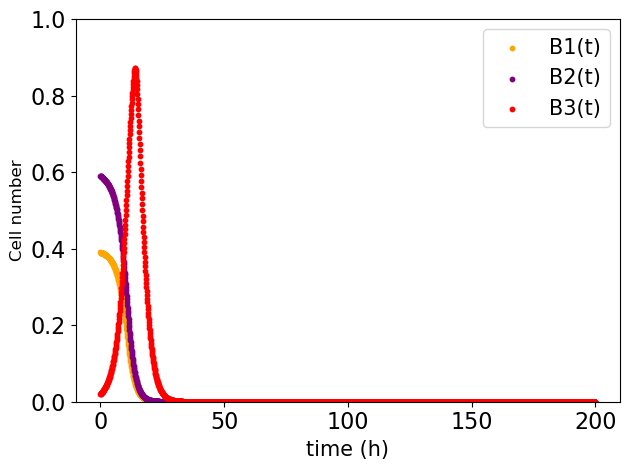

In [252]:
### 𝛆=1
import matplotlib.pyplot as plt
plt.figure()
T_list=[0]
Fluxes1_list=[0.1933]
Fluxes2_list=[0.2899]
Fluxes3_list=[0.0168]
B1_vals=[0.39]
B2_vals=[0.59]
B3_vals=[0.02]

def B1(t):
    if(t<=0):
        return 0.39
    return B1_vals[int((t-1)/1)]*0.95+0.1*Fluxes1_list[-1]
def B2(t):
    if(t<=0):
        return 0.59
    return B2_vals[int((t-1)/1)]*0.95+0.1*Fluxes2_list[-1]
def B3(t):
    if(t<=0):
        return 0.02
    return B3_vals[int((t-1)/1)]*0.95+0.1*Fluxes3_list[-1]
A=0
B=1
for t in np.arange(1,2000,1):
    B1_t = B1(t)
    B2_t = B2(t)
    B3_t = B3(t)
#     B1_vals.append(B1_t)
#     B2_vals.append(B2_t)
#     B3_vals.append(B3_t)
        
    b1=0.5*0.2*B1_vals[-1]*(math.pow(B2_vals[-1],B))/(0.2*B1_vals[-1]*(math.pow(B2_vals[-1],B))+0.3*B2_vals[-1]*(math.pow(B1_vals[-1],B))+0.2*B3_vals[-1]*(math.pow(B2_vals[-1],A)))
    b2=0.5*0.3*B2_vals[-1]*(math.pow(B1_vals[-1],B))/(0.2*B1_vals[-1]*(math.pow(B2_vals[-1],B))+0.3*B2_vals[-1]*(math.pow(B1_vals[-1],B))+0.2*B3_vals[-1]*(math.pow(B2_vals[-1],A)))
    b3=0.5*0.2*B3_vals[-1]*(math.pow(B2_vals[-1],A))/(0.2*B1_vals[-1]*(math.pow(B2_vals[-1],B))+0.3*B2_vals[-1]*(math.pow(B1_vals[-1],B))+0.2*B3_vals[-1]*(math.pow(B2_vals[-1],A)))
    
    B1_vals.append(B1_t)
    B2_vals.append(B2_t)
    B3_vals.append(B3_t)
    
    model2.reactions.biomass3.upper_bound=b3
    model2.reactions.biomass2.upper_bound=b2
    model2.reactions.biomass1.upper_bound=b1
    model2.reactions.DI1X.upper_bound=3*B1_vals[-1]
    model2.reactions.DI2Y.upper_bound=3*B2_vals[-1]
    model2.reactions.DI3X.upper_bound=3*B3_vals[-1]
    sol = model2.optimize()
    obj_val = sol.objective_value
    Fluxes3=sol.fluxes.loc['biomass3']
    Fluxes2=sol.fluxes.loc['biomass2']
    Fluxes1=sol.fluxes.loc['biomass1']

    Fluxes1_list.append(Fluxes1)
    Fluxes2_list.append(Fluxes2)
    Fluxes3_list.append(Fluxes3)

    T=t/10
    T_list.append(T)        
print(Fluxes1_list[0],Fluxes2_list[0],Fluxes3_list[0])

# plt.scatter(T_list,Fluxes1_list,color='orange',s=10)
# plt.scatter(T_list,Fluxes2_list,color='purple',s=10)
# plt.scatter(T_list,Fluxes3_list,color='red',s=10)
plt.scatter(T_list,B1_vals,color='orange',s=10)
plt.scatter(T_list,B2_vals,color='purple',s=10)
plt.scatter(T_list,B3_vals,color='red',s=10)

plt.xlabel("time (h)",fontsize=15)

# plt.ylim(0,0.5)
# plt.ylabel("Biomass synthesis rate", fontsize=12)
# plt.legend(['b1(t)','b2(t)','b3(t)'],loc='upper right')

plt.ylim(0,1)
plt.ylabel("Cell number",fontsize=12)
plt.legend(['B1(t)','B2(t)','B3(t)'],loc='upper right')

plt.rc('xtick', labelsize=16) 
plt.rc('ytick', labelsize=16)
plt.rcParams['legend.fontsize']=15
plt.tight_layout()
plt.show()
# plt.savefig('Regulation reaction lower bound for biomass1 and biomass2(Obj=b1+b2+b3)(without system break)',dpi=300)

In [254]:
import pandas as pd
df1 = pd.DataFrame(columns=['Cell1 number'])
df2 = pd.DataFrame(columns=['Cell2 number'])
df3 = pd.DataFrame(columns=['Cell3 number'])
for i in range(2000):
    df1.loc[i] = B1_vals[i]
    df2.loc[i] = B2_vals[i]
    df3.loc[i] = B3_vals[i]
writer1 = pd.ExcelWriter("cell type1.xlsx")
writer2 = pd.ExcelWriter("cell type2.xlsx")
writer3 = pd.ExcelWriter("cell type3.xlsx")
df1.to_excel(writer1, sheet_name="Cell1")
df2.to_excel(writer2, sheet_name="Cell2")
df3.to_excel(writer3, sheet_name="Cell3")
writer1.save()
writer2.save()
writer3.save()
writer1.close()
writer2.close()
writer3.close()

/var/folders/d7/l6g7ly057s9bcdclxhvjs64h0000gn/T/ipykernel_12179/719053100.py:15: FutureWarning: save is not part of the public API, usage can give in unexpected results and will be removed in a future version
  writer1.save()
/var/folders/d7/l6g7ly057s9bcdclxhvjs64h0000gn/T/ipykernel_12179/719053100.py:16: FutureWarning: save is not part of the public API, usage can give in unexpected results and will be removed in a future version
  writer2.save()
/var/folders/d7/l6g7ly057s9bcdclxhvjs64h0000gn/T/ipykernel_12179/719053100.py:17: FutureWarning: save is not part of the public API, usage can give in unexpected results and will be removed in a future version
  writer3.save()


### Simulate Warburg mutation

In [144]:
# import map visualization tools
from utils import show_map
import escher
map_loc = 'Three_cells_system_modelIIIMap.json' # the escher map used below
# show all output
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

M = cobra.io.load_json_model('Three_cells_system_modelIII.json')
model = M.copy()

In [145]:
b = show_map([],map_loc)
b

An empty solution was passed.


Builder(hide_secondary_metabolites=False, highlight_missing=True, reaction_data={}, reaction_scale=[{'type': '…

In [146]:
### Internal goods X and Y
model.reactions.EX_Com_goodX_e.lower_bound=0
model.reactions.EX_Com_goodY_e.lower_bound=0
model.reactions.EX_glucose_e.lower_bound=-1
quadratic_objective = M.problem.Objective(model.reactions.biomass1.flux_expression +
    model.reactions.biomass2.flux_expression + model.reactions.biomass3.flux_expression ,direction='max')
model.objective = quadratic_objective

In [147]:
sol = model.optimize()
sol.objective_value
fbasol = model.optimize()
b = show_map(fbasol,map_loc)
b

0.5

Builder(hide_secondary_metabolites=False, highlight_missing=True, reaction_data={'EX_glucose_e': -1.0, 'GlcT':…

In [187]:
import math
model1=model.copy()
model2=model1.copy()

<Figure size 640x480 with 0 Axes>

0.1933 0.2899 0.0112


(0.0, 1.0)

Text(0, 0.5, 'Cell number')

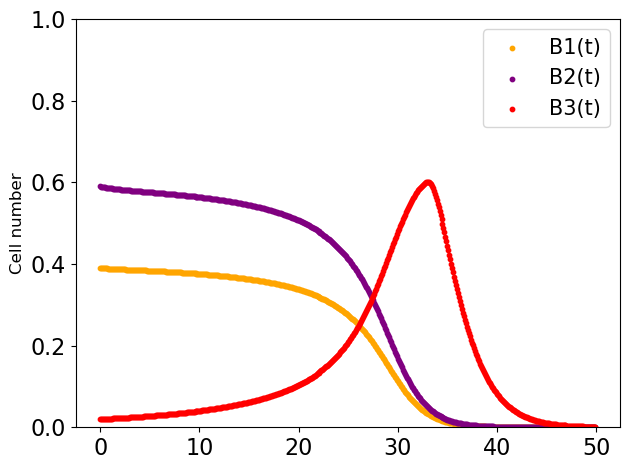

In [188]:
### 𝛆=1
import matplotlib.pyplot as plt
plt.figure()
T_list=[0]
Fluxes1_list=[0.1933]
Fluxes2_list=[0.2899]
Fluxes3_list=[0.0112]
B1_vals=[0.39]
B2_vals=[0.59]
B3_vals=[0.02]

def B1(t):
    if(t<=0):
        return 0.39
    return B1_vals[int((t-1)/1)]*0.95+0.1*Fluxes1_list[-1]
def B2(t):
    if(t<=0):
        return 0.59
    return B2_vals[int((t-1)/1)]*0.95+0.1*Fluxes2_list[-1]
def B3(t):
    if(t<=0):
        return 0.02
    return B3_vals[int((t-1)/1)]*0.95+0.1*Fluxes3_list[-1]
A=0
B=1
for t in np.arange(1,500,1):
    B1_t = B1(t)
    B2_t = B2(t)
    B3_t = B3(t)
#     B1_vals.append(B1_t)
#     B2_vals.append(B2_t)
#     B3_vals.append(B3_t)
        
    b1=0.5*0.2*B1_vals[-1]*(math.pow(B2_vals[-1],B))/(0.2*B1_vals[-1]*(math.pow(B2_vals[-1],B))+0.3*B2_vals[-1]*(math.pow(B1_vals[-1],B))+0.2*B3_vals[-1]*(math.pow(B2_vals[-1],A)))
    b2=0.5*0.3*B2_vals[-1]*(math.pow(B1_vals[-1],B))/(0.2*B1_vals[-1]*(math.pow(B2_vals[-1],B))+0.3*B2_vals[-1]*(math.pow(B1_vals[-1],B))+0.2*B3_vals[-1]*(math.pow(B2_vals[-1],A)))
    b3=0.5*0.2*B3_vals[-1]*(math.pow(B2_vals[-1],A))/(0.2*B1_vals[-1]*(math.pow(B2_vals[-1],B))+0.3*B2_vals[-1]*(math.pow(B1_vals[-1],B))+0.2*B3_vals[-1]*(math.pow(B2_vals[-1],A)))
    
    B1_vals.append(B1_t)
    B2_vals.append(B2_t)
    B3_vals.append(B3_t)
    
    model2.reactions.biomass3.upper_bound=b3
    model2.reactions.biomass2.upper_bound=b2
    model2.reactions.biomass1.upper_bound=b1
    model2.reactions.DI1X.upper_bound=3*B1_vals[-1]
    model2.reactions.DI2Y.upper_bound=3*B2_vals[-1]
    model2.reactions.DI3X.upper_bound=3*B3_vals[-1]
    sol = model2.optimize()
    obj_val = sol.objective_value
    Fluxes3=sol.fluxes.loc['biomass3']
    Fluxes2=sol.fluxes.loc['biomass2']
    Fluxes1=sol.fluxes.loc['biomass1']

    Fluxes1_list.append(Fluxes1)
    Fluxes2_list.append(Fluxes2)
    Fluxes3_list.append(Fluxes3)

    T=t/10
    T_list.append(T)        
print(Fluxes1_list[0],Fluxes2_list[0],Fluxes3_list[0])

# plt.scatter(T_list,Fluxes1_list,color='orange',s=10)
# plt.scatter(T_list,Fluxes2_list,color='purple',s=10)
# plt.scatter(T_list,Fluxes3_list,color='red',s=10)
plt.scatter(T_list,B1_vals,color='orange',s=10)
plt.scatter(T_list,B2_vals,color='purple',s=10)
plt.scatter(T_list,B3_vals,color='red',s=10)


# plt.xlabel("time (h)",fontsize=15)
# plt.ylim(0,0.5)
# plt.ylabel("Biomass synthesis rate", fontsize=12)
# plt.legend(['b1(t)','b2(t)','b3(t)'],loc='upper right')

plt.ylim(0,1)
plt.ylabel("Cell number",fontsize=12)
plt.legend(['B1(t)','B2(t)','B3(t)'],loc='upper right')

plt.rc('xtick', labelsize=16) 
plt.rc('ytick', labelsize=16)
plt.rcParams['legend.fontsize']=15
plt.tight_layout()
plt.show()
# plt.savefig('Regulation reaction lower bound for biomass1 and biomass2(Obj=b1+b2+b3)(without system break)',dpi=300)

#### Treatment 1 (when tumor cell number over than 0.1)---decreasing glucose concentration

In [236]:
import math
model1=model.copy()
model1.reactions.EX_glucose_e.lower_bound=-0.5
model2=model1.copy()

<Figure size 640x480 with 0 Axes>

0.0812 0.1218 0.0313


(0.0, 1.0)

Text(0, 0.5, 'Cell number')

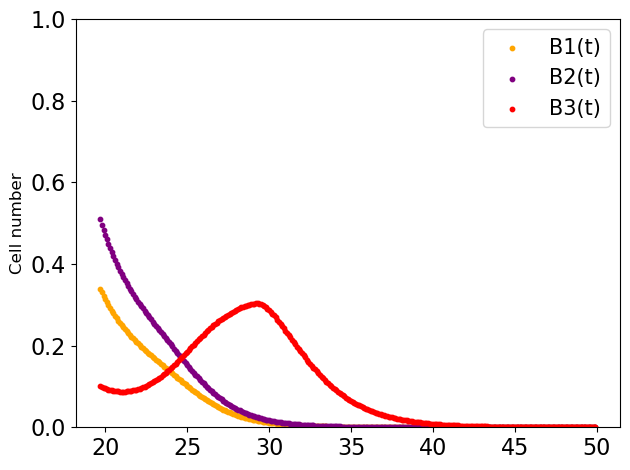

In [237]:
### 𝛆=1
import matplotlib.pyplot as plt
plt.figure()
T_list=[19.7]
Fluxes1_list=[0.0812]
Fluxes2_list=[0.1218]
Fluxes3_list=[0.0313]
B1_vals=[0.3398]
B2_vals=[0.5097]
B3_vals=[0.1003]

def B1(t):
    if(t<=197):
        return 0.3398
    return B1_vals[int((t-198)/1)]*0.95+0.1*Fluxes1_list[-1]
def B2(t):
    if(t<=197):
        return 0.5097
    return B2_vals[int((t-198)/1)]*0.95+0.1*Fluxes2_list[-1]
def B3(t):
    if(t<=197):
        return 0.1003
    return B3_vals[int((t-198)/1)]*0.95+0.1*Fluxes3_list[-1]
A=0
B=1
for t in np.arange(198,500,1):
    B1_t = B1(t)
    B2_t = B2(t)
    B3_t = B3(t)
#     B1_vals.append(B1_t)
#     B2_vals.append(B2_t)
#     B3_vals.append(B3_t)
        
    b1=0.25*0.2*B1_vals[-1]*(math.pow(B2_vals[-1],B))/(0.2*B1_vals[-1]*(math.pow(B2_vals[-1],B))+0.3*B2_vals[-1]*(math.pow(B1_vals[-1],B))+0.2*B3_vals[-1]*(math.pow(B2_vals[-1],A)))
    b2=0.25*0.3*B2_vals[-1]*(math.pow(B1_vals[-1],B))/(0.2*B1_vals[-1]*(math.pow(B2_vals[-1],B))+0.3*B2_vals[-1]*(math.pow(B1_vals[-1],B))+0.2*B3_vals[-1]*(math.pow(B2_vals[-1],A)))
    b3=0.25*0.2*B3_vals[-1]*(math.pow(B2_vals[-1],A))/(0.2*B1_vals[-1]*(math.pow(B2_vals[-1],B))+0.3*B2_vals[-1]*(math.pow(B1_vals[-1],B))+0.2*B3_vals[-1]*(math.pow(B2_vals[-1],A)))
    
    B1_vals.append(B1_t)
    B2_vals.append(B2_t)
    B3_vals.append(B3_t)
    
    model2.reactions.biomass3.upper_bound=b3
    model2.reactions.biomass2.upper_bound=b2
    model2.reactions.biomass1.upper_bound=b1
    model2.reactions.DI1X.upper_bound=3*B1_vals[-1]
    model2.reactions.DI2Y.upper_bound=3*B2_vals[-1]
    model2.reactions.DI3X.upper_bound=3*B3_vals[-1]
    sol = model2.optimize()
    obj_val = sol.objective_value
    Fluxes3=sol.fluxes.loc['biomass3']
    Fluxes2=sol.fluxes.loc['biomass2']
    Fluxes1=sol.fluxes.loc['biomass1']

    Fluxes1_list.append(Fluxes1)
    Fluxes2_list.append(Fluxes2)
    Fluxes3_list.append(Fluxes3)

    T=t/10
    T_list.append(T)        
print(Fluxes1_list[0],Fluxes2_list[0],Fluxes3_list[0])

# plt.scatter(T_list,Fluxes1_list,color='orange',s=10)
# plt.scatter(T_list,Fluxes2_list,color='purple',s=10)
# plt.scatter(T_list,Fluxes3_list,color='red',s=10)
plt.scatter(T_list,B1_vals,color='orange',s=10)
plt.scatter(T_list,B2_vals,color='purple',s=10)
plt.scatter(T_list,B3_vals,color='red',s=10)


# plt.xlabel("time (h)",fontsize=15)
# plt.ylim(0,0.5)
# plt.ylabel("Biomass synthesis rate", fontsize=12)
# plt.legend(['b1(t)','b2(t)','b3(t)'],loc='upper right')

plt.ylim(0,1)
plt.ylabel("Cell number",fontsize=12)
plt.legend(['B1(t)','B2(t)','B3(t)'],loc='upper right')

plt.rc('xtick', labelsize=16) 
plt.rc('ytick', labelsize=16)
plt.rcParams['legend.fontsize']=15
plt.tight_layout()
plt.show()
# plt.savefig('Regulation reaction lower bound for biomass1 and biomass2(Obj=b1+b2+b3)(without system break)',dpi=300)

In [238]:
import pandas as pd
df1 = pd.DataFrame(columns=['Cell1 number'])
df2 = pd.DataFrame(columns=['Cell2 number'])
df3 = pd.DataFrame(columns=['Cell3 number'])
for i in range(303):
    df1.loc[i] = B1_vals[i]
    df2.loc[i] = B2_vals[i]
    df3.loc[i] = B3_vals[i]
writer1 = pd.ExcelWriter("cell type1.xlsx")
writer2 = pd.ExcelWriter("cell type2.xlsx")
writer3 = pd.ExcelWriter("cell type3.xlsx")
df1.to_excel(writer1, sheet_name="Cell1")
df2.to_excel(writer2, sheet_name="Cell2")
df3.to_excel(writer3, sheet_name="Cell3")
writer1.save()
writer2.save()
writer3.save()
writer1.close()
writer2.close()
writer3.close()

/var/folders/d7/l6g7ly057s9bcdclxhvjs64h0000gn/T/ipykernel_12179/3150513902.py:15: FutureWarning: save is not part of the public API, usage can give in unexpected results and will be removed in a future version
  writer1.save()
/var/folders/d7/l6g7ly057s9bcdclxhvjs64h0000gn/T/ipykernel_12179/3150513902.py:16: FutureWarning: save is not part of the public API, usage can give in unexpected results and will be removed in a future version
  writer2.save()
/var/folders/d7/l6g7ly057s9bcdclxhvjs64h0000gn/T/ipykernel_12179/3150513902.py:17: FutureWarning: save is not part of the public API, usage can give in unexpected results and will be removed in a future version
  writer3.save()


#### Treatment 2 (when tumor cell number over than 0.4)---decreasing glucose concentration

In [231]:
import math
model1=model.copy()
model1.reactions.EX_glucose_e.lower_bound=-0.5
model2=model1.copy()

<Figure size 640x480 with 0 Axes>

0.0639 0.0959 0.0602


Text(0.5, 0, 'time (h)')

(0.0, 1.0)

Text(0, 0.5, 'Cell number')

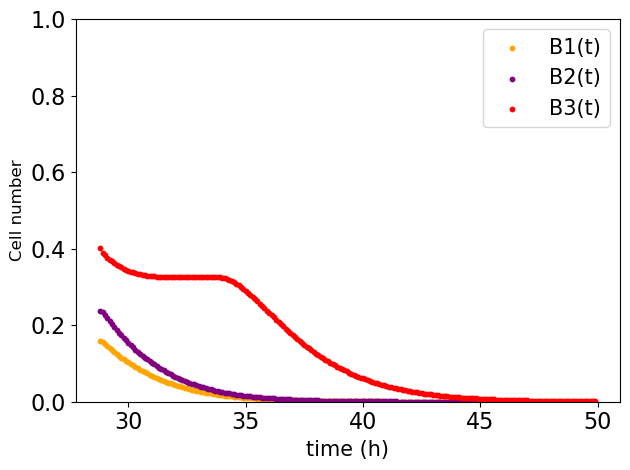

In [232]:
### 𝛆=1
import matplotlib.pyplot as plt
plt.figure()
T_list=[28.8]
Fluxes1_list=[0.0639]
Fluxes2_list=[0.0959]
Fluxes3_list=[0.0602]
B1_vals=[0.1587]
B2_vals=[0.2380]
B3_vals=[0.4022]

def B1(t):
    if(t<=288):
        return 0.1587
    return B1_vals[int((t-289)/1)]*0.95+0.1*Fluxes1_list[-1]
def B2(t):
    if(t<=288):
        return 0.2380
    return B2_vals[int((t-289)/1)]*0.95+0.1*Fluxes2_list[-1]
def B3(t):
    if(t<=288):
        return 0.4022
    return B3_vals[int((t-289)/1)]*0.95+0.1*Fluxes3_list[-1]
A=0
B=1
for t in np.arange(289,500,1):
    B1_t = B1(t)
    B2_t = B2(t)
    B3_t = B3(t)
#     B1_vals.append(B1_t)
#     B2_vals.append(B2_t)
#     B3_vals.append(B3_t)
        
    b1=0.25*0.2*B1_vals[-1]*(math.pow(B2_vals[-1],B))/(0.2*B1_vals[-1]*(math.pow(B2_vals[-1],B))+0.3*B2_vals[-1]*(math.pow(B1_vals[-1],B))+0.2*B3_vals[-1]*(math.pow(B2_vals[-1],A)))
    b2=0.25*0.3*B2_vals[-1]*(math.pow(B1_vals[-1],B))/(0.2*B1_vals[-1]*(math.pow(B2_vals[-1],B))+0.3*B2_vals[-1]*(math.pow(B1_vals[-1],B))+0.2*B3_vals[-1]*(math.pow(B2_vals[-1],A)))
    b3=0.25*0.2*B3_vals[-1]*(math.pow(B2_vals[-1],A))/(0.2*B1_vals[-1]*(math.pow(B2_vals[-1],B))+0.3*B2_vals[-1]*(math.pow(B1_vals[-1],B))+0.2*B3_vals[-1]*(math.pow(B2_vals[-1],A)))
    
    B1_vals.append(B1_t)
    B2_vals.append(B2_t)
    B3_vals.append(B3_t)
    
    model2.reactions.biomass3.upper_bound=b3
    model2.reactions.biomass2.upper_bound=b2
    model2.reactions.biomass1.upper_bound=b1
    model2.reactions.DI1X.upper_bound=3*B1_vals[-1]
    model2.reactions.DI2Y.upper_bound=3*B2_vals[-1]
    model2.reactions.DI3X.upper_bound=3*B3_vals[-1]
    sol = model2.optimize()
    obj_val = sol.objective_value
    Fluxes3=sol.fluxes.loc['biomass3']
    Fluxes2=sol.fluxes.loc['biomass2']
    Fluxes1=sol.fluxes.loc['biomass1']

    Fluxes1_list.append(Fluxes1)
    Fluxes2_list.append(Fluxes2)
    Fluxes3_list.append(Fluxes3)

    T=t/10
    T_list.append(T)        
print(Fluxes1_list[0],Fluxes2_list[0],Fluxes3_list[0])

# plt.scatter(T_list,Fluxes1_list,color='orange',s=10)
# plt.scatter(T_list,Fluxes2_list,color='purple',s=10)
# plt.scatter(T_list,Fluxes3_list,color='red',s=10)
plt.scatter(T_list,B1_vals,color='orange',s=10)
plt.scatter(T_list,B2_vals,color='purple',s=10)
plt.scatter(T_list,B3_vals,color='red',s=10)


plt.xlabel("time (h)",fontsize=15)
# plt.ylim(0,0.5)
# plt.ylabel("Biomass synthesis rate", fontsize=12)
# plt.legend(['b1(t)','b2(t)','b3(t)'],loc='upper right')

plt.ylim(0,1)
plt.ylabel("Cell number",fontsize=12)
plt.legend(['B1(t)','B2(t)','B3(t)'],loc='upper right')

plt.rc('xtick', labelsize=16) 
plt.rc('ytick', labelsize=16)
plt.rcParams['legend.fontsize']=15
plt.tight_layout()
plt.show()
# plt.savefig('Regulation reaction lower bound for biomass1 and biomass2(Obj=b1+b2+b3)(without system break)',dpi=300)

In [233]:
import pandas as pd
df1 = pd.DataFrame(columns=['Cell1 number'])
df2 = pd.DataFrame(columns=['Cell2 number'])
df3 = pd.DataFrame(columns=['Cell3 number'])
for i in range(212):
    df1.loc[i] = B1_vals[i]
    df2.loc[i] = B2_vals[i]
    df3.loc[i] = B3_vals[i]
writer1 = pd.ExcelWriter("cell type1.xlsx")
writer2 = pd.ExcelWriter("cell type2.xlsx")
writer3 = pd.ExcelWriter("cell type3.xlsx")
df1.to_excel(writer1, sheet_name="Cell1")
df2.to_excel(writer2, sheet_name="Cell2")
df3.to_excel(writer3, sheet_name="Cell3")
writer1.save()
writer2.save()
writer3.save()
writer1.close()
writer2.close()
writer3.close()

/var/folders/d7/l6g7ly057s9bcdclxhvjs64h0000gn/T/ipykernel_12179/1075205644.py:15: FutureWarning: save is not part of the public API, usage can give in unexpected results and will be removed in a future version
  writer1.save()
/var/folders/d7/l6g7ly057s9bcdclxhvjs64h0000gn/T/ipykernel_12179/1075205644.py:16: FutureWarning: save is not part of the public API, usage can give in unexpected results and will be removed in a future version
  writer2.save()
/var/folders/d7/l6g7ly057s9bcdclxhvjs64h0000gn/T/ipykernel_12179/1075205644.py:17: FutureWarning: save is not part of the public API, usage can give in unexpected results and will be removed in a future version
  writer3.save()


In [185]:
import math
model1=model.copy()
model1.reactions.EX_glucose_e.lower_bound=-1
model2=model1.copy()

<Figure size 640x480 with 0 Axes>

0.11908858819388443 0.1786328822908266 0.1348523530101926


Text(0.5, 0, 'time (h)')

(0.0, 1.0)

Text(0, 0.5, 'Cell number')

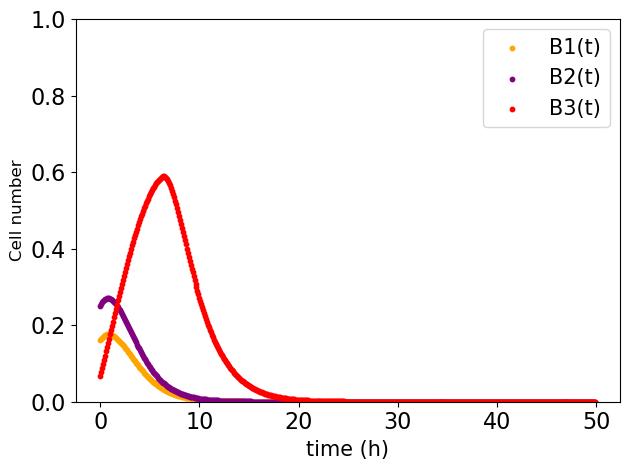

In [186]:
### 𝛆=1
import matplotlib.pyplot as plt
plt.figure()
T_list=[]
Fluxes1_list=[]
Fluxes2_list=[]
Fluxes3_list=[]
B1_vals=[]
B2_vals=[]
B3_vals=[]

def B1(t):
    if(t<=0):
        return 0.1605
    return B1_vals[int((t-1)/1)]*0.95+0.1*Fluxes1_list[-1]
def B2(t):
    if(t<=0):
        return 0.2498
    return B2_vals[int((t-1)/1)]*0.95+0.1*Fluxes2_list[-1]
def B3(t):
    if(t<=0):
        return 0.0681
    return B3_vals[int((t-1)/1)]*0.95+0.1*Fluxes3_list[-1]
A=0
B=1
for t in np.arange(0,500,1):
    B1_t = B1(t)
    B2_t = B2(t)
    B3_t = B3(t)
    B1_vals.append(B1_t)
    B2_vals.append(B2_t)
    B3_vals.append(B3_t)
        
    b1=0.5*0.2*B1_vals[-1]*(math.pow(B2_vals[-1],B))/(0.2*B1_vals[-1]*(math.pow(B2_vals[-1],B))+0.3*B2_vals[-1]*(math.pow(B1_vals[-1],B))+0.2*B3_vals[-1]*(math.pow(B2_vals[-1],A)))
    b2=0.5*0.3*B2_vals[-1]*(math.pow(B1_vals[-1],B))/(0.2*B1_vals[-1]*(math.pow(B2_vals[-1],B))+0.3*B2_vals[-1]*(math.pow(B1_vals[-1],B))+0.2*B3_vals[-1]*(math.pow(B2_vals[-1],A)))
    b3=0.5*0.2*B3_vals[-1]*(math.pow(B2_vals[-1],A))/(0.2*B1_vals[-1]*(math.pow(B2_vals[-1],B))+0.3*B2_vals[-1]*(math.pow(B1_vals[-1],B))+0.2*B3_vals[-1]*(math.pow(B2_vals[-1],A)))
    
#     B1_vals.append(B1_t)
#     B2_vals.append(B2_t)
#     B3_vals.append(B3_t)
    
    model2.reactions.biomass3.upper_bound=b3
    model2.reactions.biomass2.upper_bound=b2
    model2.reactions.biomass1.upper_bound=b1
    model2.reactions.DI1X.upper_bound=3*B1_vals[-1]
    model2.reactions.DI2Y.upper_bound=3*B2_vals[-1]
    model2.reactions.DI3X.upper_bound=3*B3_vals[-1]
    sol = model2.optimize()
    obj_val = sol.objective_value
    Fluxes3=sol.fluxes.loc['biomass3']
    Fluxes2=sol.fluxes.loc['biomass2']
    Fluxes1=sol.fluxes.loc['biomass1']

    Fluxes1_list.append(Fluxes1)
    Fluxes2_list.append(Fluxes2)
    Fluxes3_list.append(Fluxes3)

    T=t/10
    T_list.append(T)        
print(Fluxes1_list[0],Fluxes2_list[0],Fluxes3_list[0])

# plt.scatter(T_list,Fluxes1_list,color='orange',s=10)
# plt.scatter(T_list,Fluxes2_list,color='purple',s=10)
# plt.scatter(T_list,Fluxes3_list,color='red',s=10)
plt.scatter(T_list,B1_vals,color='orange',s=10)
plt.scatter(T_list,B2_vals,color='purple',s=10)
plt.scatter(T_list,B3_vals,color='red',s=10)


plt.xlabel("time (h)",fontsize=15)
# plt.ylim(0,0.5)
# plt.ylabel("Biomass synthesis rate", fontsize=12)
# plt.legend(['b1(t)','b2(t)','b3(t)'],loc='upper right')

plt.ylim(0,1)
plt.ylabel("Cell number",fontsize=12)
plt.legend(['B1(t)','B2(t)','B3(t)'],loc='upper right')

plt.rc('xtick', labelsize=16) 
plt.rc('ytick', labelsize=16)
plt.rcParams['legend.fontsize']=15
plt.tight_layout()
plt.show()
# plt.savefig('Regulation reaction lower bound for biomass1 and biomass2(Obj=b1+b2+b3)(without system break)',dpi=300)

### Four cell types in the system

###Now, we simulate a case where four cell types inside, cell type3 is the mutant of cell type1 and cell type4 is from drug resistance.

In [66]:
# import map visualization tools
from utils import show_map
import escher
map_loc = 'Three_cells_system_modelIVMap.json' # the escher map used below
# show all output
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

M = cobra.io.load_json_model('Three_cells_system_modelIV.json')
model = M.copy()

In [67]:
b = show_map([],map_loc)
b

An empty solution was passed.


Builder(hide_secondary_metabolites=False, highlight_missing=True, reaction_data={}, reaction_scale=[{'type': '…

In [68]:
### Internal goods X and Y
model.reactions.EX_Com_goodX_e.lower_bound=0
model.reactions.EX_Com_goodY_e.lower_bound=0
model.reactions.EX_glucose_e.lower_bound=-1
quadratic_objective = M.problem.Objective(model.reactions.biomass1.flux_expression +
    model.reactions.biomass2.flux_expression + model.reactions.biomass3.flux_expression ,direction='max')
model.objective = quadratic_objective

In [69]:
sol = model.optimize()
sol.objective_value
fbasol = model.optimize()
b = show_map(fbasol,map_loc)
b

0.5

Builder(hide_secondary_metabolites=False, highlight_missing=True, reaction_data={'EX_glucose_e': -1.0, 'GlcT':…

In [77]:
import math
model1=model.copy()
model2=model1.copy()

##t=50months new cell type (type 4) has drug resistance.

<Figure size 640x480 with 0 Axes>

0.1749 0.2623 0.0521 0.0107


Text(0.5, 0, 'time (h)')

(0.0, 0.5)

Text(0, 0.5, 'Biomass synthesis rate')

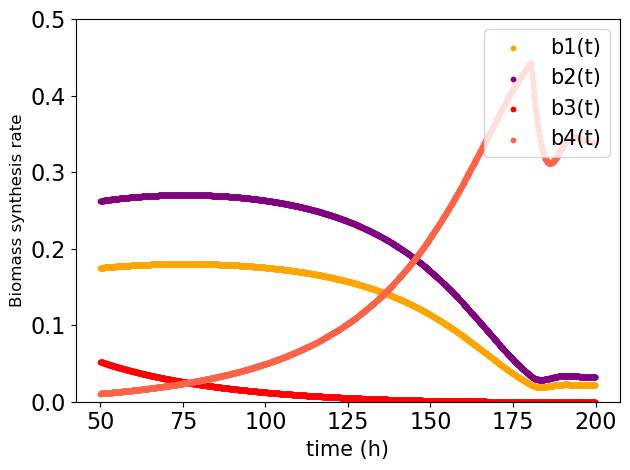

In [78]:
### 𝛆=1
import matplotlib.pyplot as plt
plt.figure()
T_list=[50]
Fluxes1_list=[0.1749]
Fluxes2_list=[0.2623]
Fluxes3_list=[0.0521]
Fluxes4_list=[0.0107]
B1_vals=[0.3478]
B2_vals=[0.5216]
B3_vals=[0.1106]
B4_vals=[0.02]
def B1(t):
    if(t<=500):
        return 0.3478
    return B1_vals[int((t-501)/1)]*0.95+0.1*Fluxes1_list[-1]
def B2(t):
    if(t<=500):
        return 0.5216
    return B2_vals[int((t-501)/1)]*0.95+0.1*Fluxes2_list[-1]
def B3(t):
    if(t<=500):
        return 0.1106
    return B3_vals[int((t-501)/1)]*0.95+0.1*Fluxes3_list[-1]
def B4(t):
    if(t<=500):
        return 0.02
    return B4_vals[int((t-501)/1)]*0.95+0.1*Fluxes4_list[-1]
A=1.1
B=1
C=0.2
D=0.9
for t in np.arange(501,2000,1):
    B1_t = B1(t)
    B2_t = B2(t)
    B3_t = B3(t)
    B4_t = B4(t)
    
#     B1_vals.append(B1_t)
#     B2_vals.append(B2_t)
#     B3_vals.append(B3_t)
#     B4_vals.append(B4_t) 
    
    b1=0.5*0.2*B1_vals[-1]*(math.pow(B2_vals[-1],B))/(0.2*B1_vals[-1]*(math.pow(B2_vals[-1],B))+0.3*B2_vals[-1]*(math.pow(B1_vals[-1],B))+0.2*B3_vals[-1]*(math.pow(B2_vals[-1],A))+C*B4_vals[-1]*(math.pow(B2_vals[-1],D)))
    b2=0.5*0.3*B2_vals[-1]*(math.pow(B1_vals[-1],B))/(0.2*B1_vals[-1]*(math.pow(B2_vals[-1],B))+0.3*B2_vals[-1]*(math.pow(B1_vals[-1],B))+0.2*B3_vals[-1]*(math.pow(B2_vals[-1],A))+C*B4_vals[-1]*(math.pow(B2_vals[-1],D)))
    b3=0.5*0.2*B3_vals[-1]*(math.pow(B2_vals[-1],A))/(0.2*B1_vals[-1]*(math.pow(B2_vals[-1],B))+0.3*B2_vals[-1]*(math.pow(B1_vals[-1],B))+0.2*B3_vals[-1]*(math.pow(B2_vals[-1],A))+C*B4_vals[-1]*(math.pow(B2_vals[-1],D)))
    b4=0.5*C*B4_vals[-1]*(math.pow(B2_vals[-1],D))/(0.2*B1_vals[-1]*(math.pow(B2_vals[-1],B))+0.3*B2_vals[-1]*(math.pow(B1_vals[-1],B))+0.2*B3_vals[-1]*(math.pow(B2_vals[-1],A))+C*B4_vals[-1]*(math.pow(B2_vals[-1],D)))
    
    B1_vals.append(B1_t)
    B2_vals.append(B2_t)
    B3_vals.append(B3_t)
    B4_vals.append(B4_t)
                                                    
    model2.reactions.biomass3.upper_bound=b3
    model2.reactions.biomass2.upper_bound=b2
    model2.reactions.biomass1.upper_bound=b1
    model2.reactions.biomass4.upper_bound=b4
    model2.reactions.DI1X.upper_bound=3*B1_vals[-1]
    model2.reactions.DI2Y.upper_bound=3*B2_vals[-1]
    model2.reactions.DI3X.upper_bound=3*B3_vals[-1]
    model2.reactions.DI4X.upper_bound=3*B4_vals[-1]                                                
    sol = model2.optimize()
    obj_val = sol.objective_value
    Fluxes3=sol.fluxes.loc['biomass3']
    Fluxes2=sol.fluxes.loc['biomass2']
    Fluxes1=sol.fluxes.loc['biomass1']
    Fluxes4=sol.fluxes.loc['biomass4']
                                                    
    Fluxes1_list.append(Fluxes1)
    Fluxes2_list.append(Fluxes2)
    Fluxes3_list.append(Fluxes3)
    Fluxes4_list.append(Fluxes4)
                                                    
    T=t/10
    T_list.append(T)        
print(Fluxes1_list[0],Fluxes2_list[0],Fluxes3_list[0],Fluxes4_list[0])

plt.scatter(T_list,Fluxes1_list,color='orange',s=10)
plt.scatter(T_list,Fluxes2_list,color='purple',s=10)
plt.scatter(T_list,Fluxes3_list,color='red',s=10)
plt.scatter(T_list,Fluxes4_list,color='tomato',s=10)                                                    
# plt.scatter(T_list,B1_vals,color='orange',s=10)
# plt.scatter(T_list,B2_vals,color='purple',s=10)
# plt.scatter(T_list,B3_vals,color='red',s=10)
# plt.scatter(T_list,B4_vals,color='tomato',s=10)

plt.xlabel("time (h)",fontsize=15)
plt.ylim(0,0.5)
plt.ylabel("Biomass synthesis rate", fontsize=12)
plt.legend(['b1(t)','b2(t)','b3(t)','b4(t)'],loc='upper right')

# plt.ylim(0,1)
# plt.ylabel("Cell number",fontsize=12)
# plt.legend(['B1(t)','B2(t)','B3(t)','B4(t)'],loc='upper right')

plt.rc('xtick', labelsize=16) 
plt.rc('ytick', labelsize=16)
plt.rcParams['legend.fontsize']=15
plt.tight_layout()
plt.show()
# plt.savefig('Regulation reaction lower bound for biomass1 and biomass2(Obj=b1+b2+b3)(without system break)',dpi=300)

In [81]:
import pandas as pd
df1 = pd.DataFrame(columns=['Cell1 number'])
df2 = pd.DataFrame(columns=['Cell2 number'])
df3 = pd.DataFrame(columns=['Cell3 number'])
df4 = pd.DataFrame(columns=['Cell4 number'])
for i in range(1500):
    df1.loc[i] = B1_vals[i]
    df2.loc[i] = B2_vals[i]
    df3.loc[i] = B3_vals[i]
    df4.loc[i] = B4_vals[i]
writer1 = pd.ExcelWriter("cell type1.xlsx")
writer2 = pd.ExcelWriter("cell type2.xlsx")
writer3 = pd.ExcelWriter("cell type3.xlsx")
writer4 = pd.ExcelWriter("cell type4.xlsx")
df1.to_excel(writer1, sheet_name="Cell1")
df2.to_excel(writer2, sheet_name="Cell2")
df3.to_excel(writer3, sheet_name="Cell3")
df4.to_excel(writer4, sheet_name="Cell4")
writer1.save()
writer2.save()
writer3.save()
writer4.save()
writer1.close()
writer2.close()
writer3.close()
writer4.close()

/var/folders/d7/l6g7ly057s9bcdclxhvjs64h0000gn/T/ipykernel_12179/4024766525.py:19: FutureWarning: save is not part of the public API, usage can give in unexpected results and will be removed in a future version
  writer1.save()
/var/folders/d7/l6g7ly057s9bcdclxhvjs64h0000gn/T/ipykernel_12179/4024766525.py:20: FutureWarning: save is not part of the public API, usage can give in unexpected results and will be removed in a future version
  writer2.save()
/var/folders/d7/l6g7ly057s9bcdclxhvjs64h0000gn/T/ipykernel_12179/4024766525.py:21: FutureWarning: save is not part of the public API, usage can give in unexpected results and will be removed in a future version
  writer3.save()
/var/folders/d7/l6g7ly057s9bcdclxhvjs64h0000gn/T/ipykernel_12179/4024766525.py:22: FutureWarning: save is not part of the public API, usage can give in unexpected results and will be removed in a future version
  writer4.save()
